<a href="https://colab.research.google.com/github/Dianna22/NLP/blob/master/Project/Emocontext/elmok_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji

    100% |████████████████████████████████| 51kB 4.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_PREFIX = '/content/gdrive/My Drive/NLP/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import pandas as pd
a = pd.DataFrame([[1,10,3],[5,6,7]])
max(a.max())

10

In [4]:
import csv
import emoji
from keras import backend as K
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Add, Average, Maximum, Concatenate, Multiply, Dot, Minimum
from keras.layers import Dropout, Input, TimeDistributed, PReLU
from keras.models import Sequential, Model, load_model, save_model, model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.utils import to_categorical
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import tensorflow as tf
import tensorflow_hub as hub
import time

from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.
W0429 13:18:19.995782 139996005840768 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

#### Elmo layer

In [0]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

#     def compute_mask(self, inputs, mask=None):
#         return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

#### Path vars & load

In [0]:
path_prefix='/content/gdrive/My Drive/NLP/'

In [0]:
TRAIN_FILE = path_prefix + 'train.txt'
DEV_FILE =  path_prefix + 'dev.txt'
TEST_FILE =  path_prefix + 'test.txt'

TURNS_NAMES = ["turn1", "turn2", "turn3"]
LABEL = ["label"]
CONCATENATED_TURNS = "turns"
def parse_file(file_path):
    output_dict = dict()
    with open(file_path, newline='\n', encoding='utf8') as csvfile:
        return pd.read_csv(csvfile, sep="\t")

In [0]:
MODEL_CHECKPOINT = '3_elmo-turns'

In [0]:

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [0]:
train_data = parse_file(TRAIN_FILE)
dev_data = parse_file(DEV_FILE)
test_data = parse_file(TEST_FILE)

In [12]:
print(np.shape(train_data))

(30160, 5)


In [0]:
def concatenate_turns(df, delim="fullstop"):
    turns = [("%s %s %s %s %s" %
                 (row[TURNS_NAMES[0]], delim,
                  row[TURNS_NAMES[1]], delim,
                  row[TURNS_NAMES[2]])).lower()
                 for index, row in df.iterrows()]
    df[CONCATENATED_TURNS] = pd.Series(turns, index=df.index)
    return df

In [0]:
def emoticons_replace(df):
    for index, row in df.iterrows():
        for turn in range(3):
          turns = emoji.demojize(row[TURNS_NAMES[turn]])
          # remove delimiters ":"  (:smiley: -> smiley)
          for emoj in re.findall(":\w*:", turns):
              turns  = turns.replace(emoj, emoj[1:-1]).replace("_", " ")
          df.at[index, TURNS_NAMES[turn]] = turns
    return df

In [0]:
train = emoticons_replace(train_data)
dev = emoticons_replace(dev_data)
test = emoticons_replace(test_data)

In [0]:
max_sentence = [163,82,189]
### angry: [1 0 0 0]
### happy: [0 1 0 0]
### others: [0 0 1 0]
### sad: [0 0 0 1]
labels = {0: 'angry',
          1: 'happy',
          2: 'others',
          3: 'sad'}

In [17]:
### angry: [1 0 0 0]
### happy: [0 1 0 0]
### others: [0 0 1 0]
### sad: [0 0 0 1]
Y_train = pd.get_dummies(train[LABEL]).as_matrix()
# for i, t in enumerate(train[LABEL].iterrows()):
#     if t[1]['label']=='others':
#         print(Y_train[i])
#         break
Y_dev = pd.get_dummies(dev[LABEL]).as_matrix()
Y_test = pd.get_dummies(test[LABEL]).as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


#### Model Callback

In [0]:
class Metrics(Callback):
    def __init__(self, test_X, test_Y, tolerance):
        self.test_X = test_X
        self.test_Y = test_Y
        self.max_f1 = 0
        self.f1_prev = 0
        self.tolerance = tolerance
        self.decreasing_times = 0
        
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.i = 0
        self.x = []
        
        self.f1s_test = []
        self.f1s_val = []
        self.losses = []
        self.val_losses = []
        self.epoch = 0
        
        self.logs = []
        self.fig = plt.figure()
    
    def plot_losses(self, f1_val,f1_test, logs):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1s_test.append(f1_test)
        self.f1s_val.append(f1_val)
        self.i += 1
        
#         clear_output(wait=True)
        
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="train_loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.f1s_val, label="f1_val " + '{:.4f}'.format(max(self.f1s_val)))
        plt.plot(self.x, self.f1s_test, label="f1_test " + '{:.4f}, e={:d}'.format(max(self.f1s_test), self.epoch))
        
        plt.legend(loc=0)

        plt.show();

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict([self.validation_data[:3][i] for i in range(3)]))).round()
        val_targ = self.validation_data[3]

        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        predicts = self.model.predict(self.test_X)
        test_predict = (np.asarray(predicts)).round()
        f1 = print_metrics_predicted(val_predict, val_targ, MODEL_CHECKPOINT+"-results")
        print("#############\nF1 test:\n#############")
        f_test = print_metrics_predicted(test_predict, self.test_Y, MODEL_CHECKPOINT+"-results")
        self.plot_losses(f1, f_test, logs)
        if f_test > self.max_f1:
            self.max_f1 = f_test
            self.epoch = epoch
            self.model.save(MODEL_CHECKPOINT)
        if f_test < self.f1_prev:
            self.decreasing_times += 1
            if self.decreasing_times > self.tolerance:
                self.model.stop_training = True
        else:
            self.decreasing_times = 0
        self.f1_prev = f_test
        return
 
# metrics = Metrics()

def print_metrics_predicted(predicts,Y,filename):
    tp =[0,0,0,0]
    fp =[0,0,0,0]
    fn =[0,0,0,0]
    for i,pred in enumerate(predicts):
        p = np.argmax(pred)
        y = np.argmax(Y[i])
        if p == y:
            tp[p] += 1
        else:
            fp[p] +=1
            fn[y] +=1
    prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
    rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
    with open(filename, "w") as f:
      print("F1 all")
      f1_all = 2*prec*rec/(prec+rec+np.finfo(float).eps)
      print(f1_all) 
      f.write(str(f1_all))
      print("***")
      for i in range(4):
          print("F1 %s: " % labels[i])
          f.write("\n%s: " % labels[i])
          prec = tp[i]/(tp[i]+fp[i]+np.finfo(float).eps)
          rec = tp[i]/(tp[i]+fn[i]+np.finfo(float).eps)
          f1 = 2*prec*rec/(prec+rec+np.finfo(float).eps)
          print(f1)
          f.write(str(f1))
          print("****")
      tp.pop(2)
      fp.pop(2)
      fn.pop(2)
      print("F1 happy angry sad")
      f.write("\nF1 happy angry sad: ")
      prec = sum(tp)/(sum(tp+fp)+np.finfo(float).eps)
      rec = sum(tp)/(sum(tp+fn)+np.finfo(float).eps)
      f1= 2*prec*rec/(prec+rec+np.finfo(float).eps)
      f.write(str(f1))
      print(f1)
      return f1


##### Model params


In [0]:
# vocabulary_size = len(tokenizer.word_counts) + 1

epochs = 10
embed_dim = 256
lstm_out = 128
batch_size = 128
drop_out = 0.3
loss_fct = 'binary_crossentropy'
activation_fct = 'softmax'
optimizer = "Adam-0.01"

parameters = """Epochs:%s\nEmbed_dim: %s\nLstm_out: %s\nBatch size: %s\nDrop_out: %s
Loss_fct: %s\nActivaion_fct: %s\nOptimizer: %s\n
""" %(str(epochs), str(embed_dim), str(lstm_out), str(batch_size), str(drop_out), loss_fct,
      activation_fct, optimizer)

###### Modele esuate

In [0]:
# input_layer = Input(shape=(max_sentence,), dtype='int32')

# embedding_layer = Embedding(vocabulary_size,
#                             embed_dim,
#                             weights=[embedding_matrix],
#                             input_length=max_sentence,
#                             trainable=False)(input_layer)
# bi_lstm = Bidirectional(LSTM(lstm_out))(embedding_layer)
# dropout = Dropout(0.4)(bi_lstm)
# dense = Dense(128,activation=activation_fct)(dropout)
# dropout = Dropout(0.2)(dense)
# dense = Dense(4,activation=activation_fct)(dropout)
# adam = optimizers.Adam(lr=0.01)
# rmsprop = optimizers.RMSprop(lr=0.005)#, rho=0.9, epsilon=None, decay=0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model = Model(inputs=[input_layer], outputs=dense)
# model.compile(loss = loss_fct, optimizer=adam, metrics = ['accuracy'])
# print(model.summary())

In [0]:
# input_layer = Input(shape=(1,), dtype="string")
# embedding = ElmoEmbeddingLayer()(input_layer)
# # bilstm = Bidirectional(LSTM(lstm_out), input_shape=(1024,))(embedding)dr = Dropout(0.4)(embedding)
# dropout = Dropout(0.4)(embedding)
# dense = Dense(128,activation=activation_fct)(dropout)
# dropout = Dropout(0.2)(dense)
# dense = Dense(4,activation=activation_fct)(dropout)

# adam = optimizers.Adam(lr=0.01)
# rmsprop = optimizers.RMSprop(lr=0.005)#, rho=0.9, epsilon=None, decay=0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model = Model(inputs=[input_layer], outputs=dense)
# model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
# print(model.summary())

In [0]:
# input_text = Input(shape=(1,), dtype="string")
# embedding = ElmoEmbeddingLayer()(input_text)
# # bilstm = Bidirectional(LSTM(lstm_out), input_shape=(1024,))(embedding)dr = Dropout(0.4)(embedding)
# dense = Dense(1024, activation='relu')(embedding)
# dense = Dense(512, activation='relu')(dense)
# dense = Dropout(0.15)(dense)
# dense = Dense(128, activation='relu')(dense)
# dense = Dropout(0.1)(dense)
# pred = Dense(4, activation='softmax')(dense)

# model = Model(inputs=[input_text], outputs=pred)
# adam = optimizers.Adam(lr=0.003)
# model.compile(loss='mean_squared_error', optimizer= adam, metrics=['accuracy'])
# model.summary()

##### Model

#### Model architecture


In [27]:
input_layer1 = Input(shape=(1,), dtype="string")
embedding1 = ElmoEmbeddingLayer()(input_layer1)
input_layer2 = Input(shape=(1,), dtype="string")
embedding2 = ElmoEmbeddingLayer()(input_layer2)
input_layer3 = Input(shape=(1,), dtype="string")
embedding3 = ElmoEmbeddingLayer()(input_layer3)

merged = Concatenate()([embedding1, embedding2, embedding3])

dropout = Dropout(0.7)(merged)
# dense = Dense(256,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.0001))(dropout)
# dropout = Dropout(0.3)(dense)
# dense = Dense(128,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.001))(dropout)
# dropout = Dropout(0.2)(dense)
# dense = Dense(64,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.0001))(dropout)
# dropout = Dropout(0.2)(dense)
dense = Dense(4,activation='softmax')(dropout)

adam = optimizers.Adam(lr=0.01)
rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)

model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=dense)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model.summary())
# with open(MODEL_CHECKPOINT + ".json","w") as f:
#   f.write(model.to_json())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 15:37:56.840474 140707608799104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 15:37:58.111327 140707608799104 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0426 15:37:59.668245 140707608799104 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_4 (ElmoEmb (None, 1024)         4           input_4[0][0]                    
__________________________________________________________________________________________________
elmo_embed

In [0]:
# train_turns = train[TURNS_NAMES].T.values
# dev_turns = dev[TURNS_NAMES].T
# test_turns = test[TURNS_NAMES].T
# model.predict([test[TURNS_NAMES[i]] for i in range(3)])
# Y_test

### 3 models

In [20]:
input_layer1 = Input(shape=(1,), dtype="string")
embedding1 = ElmoEmbeddingLayer()(input_layer1)

embedding1 = Dropout(0.3)(embedding1)
dense = Dense(64, activation='relu')(embedding1)
dense1 = Dense(4,activation='softmax')(dense)

input_layer2 = Input(shape=(1,), dtype="string")
embedding2 = ElmoEmbeddingLayer()(input_layer2)


embedding2 = Dropout(0.3)(embedding2)
dense2 = Dense(64, activation='relu')(embedding2)
dense2 = Dense(4,activation='softmax')(dense2)


input_layer3 = Input(shape=(1,), dtype="string")
embedding3 = ElmoEmbeddingLayer()(input_layer3)


embedding3 = Dropout(0.3)(embedding3)
dense3 = Dense(64, activation='relu')(embedding3)
dense3 = Dense(4,activation='softmax')(dense3)


merged = Concatenate()([dense1, dense2, dense3])

# dropout = Dropout(0.2)(merged)
# dense = Dense(256,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.0001))(dropout)
# dropout = Dropout(0.3)(dense)
# dense = Dense(128,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.001))(dropout)
# dropout = Dropout(0.2)(dense)
# dense = Dense(64,activation='relu',
#                 kernel_regularizer=regularizers.l2(0.0001))(dropout)
# dropout = Dropout(0.2)(dense)
dense = Dense(4,activation='softmax')(merged)

adam = optimizers.Adam(lr=0.01)
rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)

model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=dense)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model.summary())
# with open(MODEL_CHECKPOINT + ".json","w") as f:
#   f.write(model.to_json())

Instructions for updating:
Colocations handled automatically by placer.


W0429 13:20:18.463858 139996005840768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0429 13:20:19.119467 139996005840768 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0429 13:20:19.180613 139996005840768 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0429 13:20:20.239543 139996005840768 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0429 13:20:21.436644 139996005840768 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_1 (ElmoEmb (None, 1024)         4           input_1[0][0]                    
__________________________________________________________________________________________________
elmo_embed

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Instructions for updating:
Use tf.cast instead.


W0429 13:20:34.801059 139996005840768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 30160 samples, validate on 2755 samples
Epoch 1/100
30160/30160 [==============================] - 226s 7ms/step - loss: 0.4116 - acc: 0.8192 - val_loss: 0.2342 - val_acc: 0.9164
— val_f1: 0.810026 — val_precision: 0.896127 — val_recall 0.739020
F1 all
0.7680580762250453
***
F1 angry: 
0.2986822840409956
****
F1 happy: 
0.4647302904564314
****
F1 others: 
0.8719269491922266
****
F1 sad: 
0.6095238095238095
****
F1 happy angry sad
0.4100080710250201
#############
F1 test:
#############
F1 all
0.7689235795970228
***
F1 angry: 
0.3156297420333838
****
F1 happy: 
0.4270613107822409
****
F1 others: 
0.8747505575771803
****
F1 sad: 
0.5677966101694915
****
F1 happy angry sad
0.40816326530612235


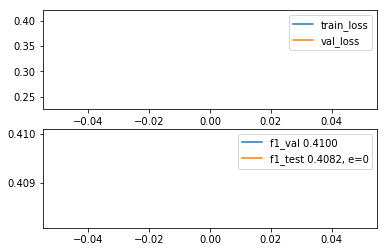

Epoch 2/100
30160/30160 [==============================] - 194s 6ms/step - loss: 0.2571 - acc: 0.8982 - val_loss: 0.1840 - val_acc: 0.9331
— val_f1: 0.859179 — val_precision: 0.888673 — val_recall 0.831579


In [0]:
model.fit([train[TURNS_NAMES[i]] for i in range(3)], Y_train, epochs=100, verbose=1,
          batch_size=128,
          validation_data=([dev[TURNS_NAMES[i]] for i in range(3)], Y_dev),
          callbacks= [ Metrics([test[TURNS_NAMES[i]] for i in range(3)], Y_test, 3),
                    ])

###dense64+d4

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
model.fit([train[TURNS_NAMES[i]] for i in range(3)], Y_train, epochs=100, verbose=1,
          batch_size=128,
          validation_data=([dev[TURNS_NAMES[i]] for i in range(3)], Y_dev),
          callbacks= [ Metrics([test[TURNS_NAMES[i]] for i in range(3)], Y_test, 3),
                    ])

### dense4

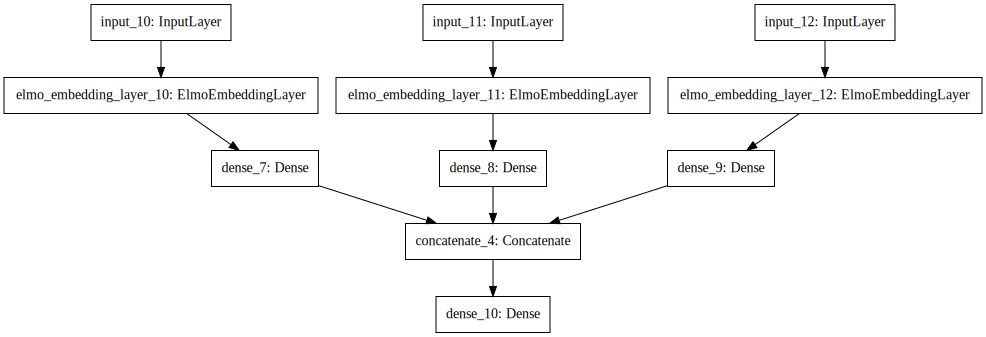

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 30160 samples, validate on 2755 samples
Epoch 1/100
30160/30160 [==============================] - 198s 7ms/step - loss: 0.3964 - acc: 0.8326 - val_loss: 0.2511 - val_acc: 0.9096
— val_f1: 0.813102 — val_precision: 0.866530 — val_recall 0.765880
F1 all
0.7796733212341196
***
F1 angry: 
0.2996742671009771
****
F1 happy: 
0.5698005698005696
****
F1 others: 
0.8722466960352422
****
F1 sad: 
0.6465517241379308
****
F1 happy angry sad
0.4461152882205513
#############
F1 test:
#############
F1 all
0.770557269921946
***
F1 angry: 
0.2778216258879242
****
F1 happy: 
0.5585023400936037
****
F1 others: 
0.869322801719131
****
F1 sad: 
0.5908183632734529
****
F1 happy angry sad
0.41760066417600655


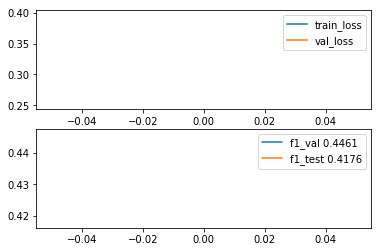

Epoch 2/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2822 - acc: 0.8882 - val_loss: 0.2166 - val_acc: 0.9202
— val_f1: 0.831204 — val_precision: 0.875804 — val_recall 0.790926
F1 all
0.8065335753176043
***
F1 angry: 
0.3689655172413792
****
F1 happy: 
0.5956112852664576
****
F1 others: 
0.8908337171810224
****
F1 sad: 
0.6394052044609665
****
F1 happy angry sad
0.49315068493150666
#############
F1 test:
#############
F1 all
0.8063169359230349
***
F1 angry: 
0.3478260869565217
****
F1 happy: 
0.5776293823038396
****
F1 others: 
0.8941526490445131
****
F1 sad: 
0.6003616636528027
****
F1 happy angry sad
0.4695041684949539


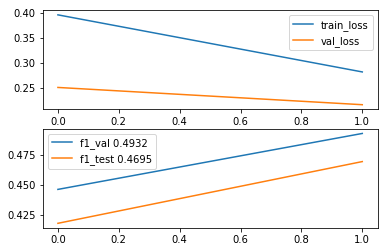

Epoch 3/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2445 - acc: 0.9015 - val_loss: 0.1779 - val_acc: 0.9367
— val_f1: 0.867214 — val_precision: 0.891830 — val_recall 0.843920
F1 all
0.8515426497277676
***
F1 angry: 
0.5099778270509977
****
F1 happy: 
0.5763688760806915
****
F1 others: 
0.9158083296014331
****
F1 sad: 
0.6991869918699185
****
F1 happy angry sad
0.5766283524904213
#############
F1 test:
#############
F1 all
0.8540569976402249
***
F1 angry: 
0.49048152295632685
****
F1 happy: 
0.578866768759571
****
F1 others: 
0.9206950323011805
****
F1 sad: 
0.6639676113360322
****
F1 happy angry sad
0.5607843137254901


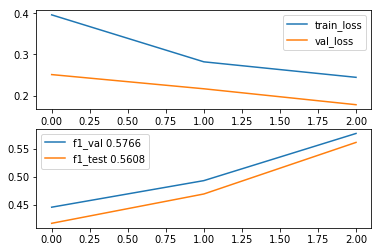

Epoch 4/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1920 - acc: 0.9292 - val_loss: 0.2047 - val_acc: 0.9237
— val_f1: 0.840585 — val_precision: 0.857899 — val_recall 0.823956
F1 all
0.8283121597096188
***
F1 angry: 
0.5354691075514872
****
F1 happy: 
0.6123595505617977
****
F1 others: 
0.8975475590190235
****
F1 sad: 
0.5536723163841806
****
F1 happy angry sad
0.5649520488230165
#############
F1 test:
#############
F1 all
0.8349972771827917
***
F1 angry: 
0.528521536670547
****
F1 happy: 
0.5935672514619881
****
F1 others: 
0.9042346764068027
****
F1 sad: 
0.5854341736694677
****
F1 happy angry sad
0.566238369517058


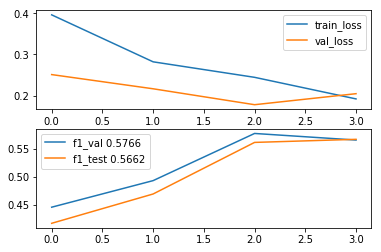

Epoch 5/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1661 - acc: 0.9389 - val_loss: 0.1735 - val_acc: 0.9348
— val_f1: 0.865534 — val_precision: 0.881158 — val_recall 0.850454
F1 all
0.8529945553539019
***
F1 angry: 
0.5361702127659573
****
F1 happy: 
0.614942528735632
****
F1 others: 
0.9143372407574389
****
F1 sad: 
0.6953125
****
F1 happy angry sad
0.5996275605214151
#############
F1 test:
#############
F1 all
0.8625884915592665
***
F1 angry: 
0.5303867403314916
****
F1 happy: 
0.641975308641975
****
F1 others: 
0.9211646136618139
****
F1 sad: 
0.7140186915887848
****
F1 happy angry sad
0.6120689655172413


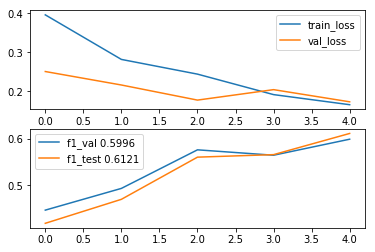

Epoch 6/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1529 - acc: 0.9442 - val_loss: 0.2129 - val_acc: 0.9200
— val_f1: 0.833579 — val_precision: 0.845723 — val_recall 0.821779
F1 all
0.8221415607985479
***
F1 angry: 
0.44982698961937706
****
F1 happy: 
0.6265822784810126
****
F1 others: 
0.8932842686292548
****
F1 sad: 
0.7014925373134326
****
F1 happy angry sad
0.5559380378657486
#############
F1 test:
#############
F1 all
0.8330005445634414
***
F1 angry: 
0.45398773006134957
****
F1 happy: 
0.6329966329966329
****
F1 others: 
0.9049195297340485
****
F1 sad: 
0.6819923371647507
****
F1 happy angry sad
0.5538325210456356


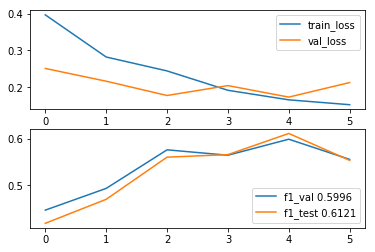

Epoch 7/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1465 - acc: 0.9467 - val_loss: 0.1972 - val_acc: 0.9250
— val_f1: 0.846423 — val_precision: 0.857942 — val_recall 0.835209
F1 all
0.8373865698729581
***
F1 angry: 
0.5119047619047618
****
F1 happy: 
0.6055555555555554
****
F1 others: 
0.9020324274948618
****
F1 sad: 
0.7041198501872658
****
F1 happy angry sad
0.5870910698496905
#############
F1 test:
#############
F1 all
0.8464331094572517
***
F1 angry: 
0.5056294779938587
****
F1 happy: 
0.6176470588235292
****
F1 others: 
0.9117947553638325
****
F1 sad: 
0.6884057971014491
****
F1 happy angry sad
0.5857854232684472


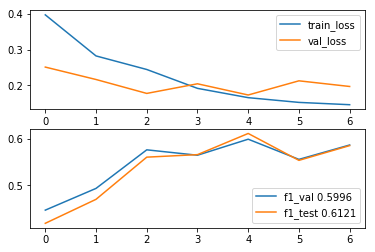

Epoch 8/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1393 - acc: 0.9492 - val_loss: 0.1894 - val_acc: 0.9289
— val_f1: 0.855725 — val_precision: 0.866716 — val_recall 0.845009
F1 all
0.8468239564428311
***
F1 angry: 
0.5454545454545453
****
F1 happy: 
0.607242339832869
****
F1 others: 
0.9088848594741613
****
F1 sad: 
0.6622073578595317
****
F1 happy angry sad
0.5974499089253187
#############
F1 test:
#############
F1 all
0.851878743873661
***
F1 angry: 
0.5336374002280501
****
F1 happy: 
0.6089466089466089
****
F1 others: 
0.9143696339810211
****
F1 sad: 
0.6744966442953019
****
F1 happy angry sad
0.5964912280701753


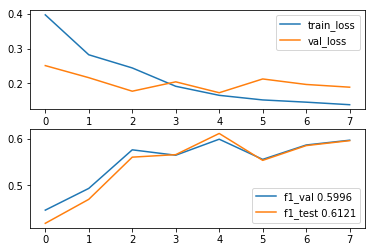

Epoch 9/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1346 - acc: 0.9516 - val_loss: 0.1915 - val_acc: 0.9314
— val_f1: 0.860917 — val_precision: 0.870501 — val_recall 0.851543
F1 all
0.8526315789473684
***
F1 angry: 
0.5260960334029227
****
F1 happy: 
0.6644951140065146
****
F1 others: 
0.9127395715896278
****
F1 sad: 
0.6712802768166087
****
F1 happy angry sad
0.6046511627906975
#############
F1 test:
#############
F1 all
0.8558722091123615
***
F1 angry: 
0.512169312169312
****
F1 happy: 
0.6484641638225254
****
F1 others: 
0.9179112857944974
****
F1 sad: 
0.6735395189003436
****
F1 happy angry sad
0.5944155229531471


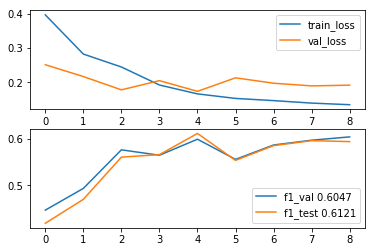

Epoch 10/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1298 - acc: 0.9535 - val_loss: 0.1724 - val_acc: 0.9385
— val_f1: 0.875275 — val_precision: 0.884687 — val_recall 0.866062
F1 all
0.8682395644283121
***
F1 angry: 
0.5925925925925926
****
F1 happy: 
0.6363636363636362
****
F1 others: 
0.9231454666963688
****
F1 sad: 
0.6643356643356642
****
F1 happy angry sad
0.6268364348677765
#############
F1 test:
#############
F1 all
0.8718460700671627
***
F1 angry: 
0.5768742058449807
****
F1 happy: 
0.6141732283464565
****
F1 others: 
0.9277161862527714
****
F1 sad: 
0.6840277777777776
****
F1 happy angry sad
0.6196196196196195


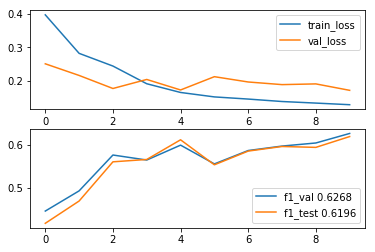

Epoch 11/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1265 - acc: 0.9545 - val_loss: 0.1946 - val_acc: 0.9292
— val_f1: 0.857615 — val_precision: 0.868304 — val_recall 0.847187
F1 all
0.8497277676950997
***
F1 angry: 
0.5687203791469193
****
F1 happy: 
0.5736842105263157
****
F1 others: 
0.9109805693628558
****
F1 sad: 
0.6808510638297871
****
F1 happy angry sad
0.599630996309963
#############
F1 test:
#############
F1 all
0.8489744055182428
***
F1 angry: 
0.5432977461447211
****
F1 happy: 
0.5604395604395603
****
F1 others: 
0.9132934941932573
****
F1 sad: 
0.6712802768166087
****
F1 happy angry sad
0.583527221963704


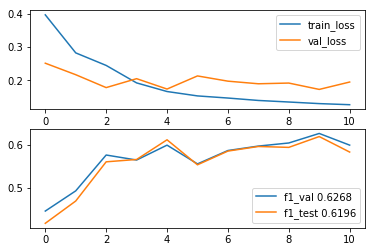

Epoch 12/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1215 - acc: 0.9562 - val_loss: 0.1888 - val_acc: 0.9328
— val_f1: 0.863886 — val_precision: 0.870896 — val_recall 0.856987
F1 all
0.858802177858439
***
F1 angry: 
0.5979899497487436
****
F1 happy: 
0.6167146974063399
****
F1 others: 
0.9161232291432425
****
F1 sad: 
0.6477987421383646
****
F1 happy angry sad
0.6190028222013169
#############
F1 test:
#############
F1 all
0.8625884915592665
***
F1 angry: 
0.5777233782129741
****
F1 happy: 
0.6089644513137557
****
F1 others: 
0.9215269226463673
****
F1 sad: 
0.6537842190016103
****
F1 happy angry sad
0.610071942446043


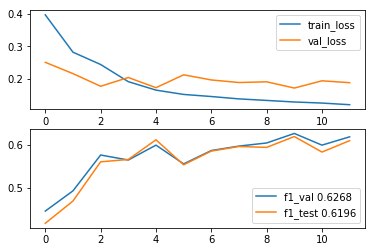

Epoch 13/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1189 - acc: 0.9577 - val_loss: 0.1751 - val_acc: 0.9392
— val_f1: 0.876692 — val_precision: 0.883807 — val_recall 0.869691
F1 all
0.8718693284936478
***
F1 angry: 
0.6015037593984961
****
F1 happy: 
0.6204819277108433
****
F1 others: 
0.9257699977841789
****
F1 sad: 
0.6766917293233081
****
F1 happy angry sad
0.6278836509528586
#############
F1 test:
#############
F1 all
0.8794699582501361
***
F1 angry: 
0.6028460543337645
****
F1 happy: 
0.6137071651090341
****
F1 others: 
0.9322594880847306
****
F1 sad: 
0.7050092764378477
****
F1 happy angry sad
0.6345957011258956


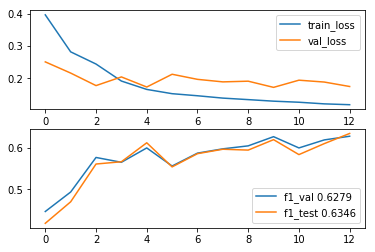

Epoch 14/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1162 - acc: 0.9583 - val_loss: 0.1764 - val_acc: 0.9392
— val_f1: 0.876898 — val_precision: 0.883850 — val_recall 0.870054
F1 all
0.8747731397459163
***
F1 angry: 
0.6332453825857518
****
F1 happy: 
0.6194690265486725
****
F1 others: 
0.9267968056787932
****
F1 sad: 
0.6760563380281689
****
F1 happy angry sad
0.6407185628742516
#############
F1 test:
#############
F1 all
0.8709384643310945
***
F1 angry: 
0.5897435897435898
****
F1 happy: 
0.5953488372093022
****
F1 others: 
0.9274944567627494
****
F1 sad: 
0.6736474694589877
****
F1 happy angry sad
0.6156156156156155


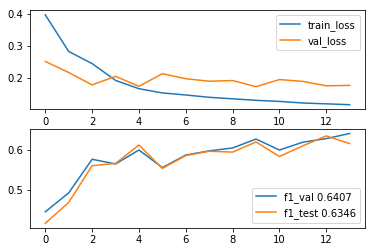

Epoch 15/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1133 - acc: 0.9604 - val_loss: 0.1984 - val_acc: 0.9308
— val_f1: 0.858918 — val_precision: 0.864925 — val_recall 0.852995
F1 all
0.8540834845735026
***
F1 angry: 
0.5499999999999999
****
F1 happy: 
0.6335403726708073
****
F1 others: 
0.9139519209166478
****
F1 sad: 
0.6464646464646464
****
F1 happy angry sad
0.6024551463644947
#############
F1 test:
#############
F1 all
0.8598656743510618
***
F1 angry: 
0.5456647398843929
****
F1 happy: 
0.6175999999999999
****
F1 others: 
0.9206846403400828
****
F1 sad: 
0.6553480475382002
****
F1 happy angry sad
0.5983645983645982


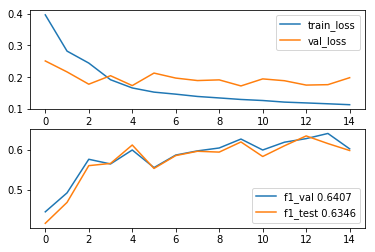

Epoch 16/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1119 - acc: 0.9608 - val_loss: 0.1901 - val_acc: 0.9347
— val_f1: 0.868930 — val_precision: 0.874036 — val_recall 0.863884
F1 all
0.8660617059891106
***
F1 angry: 
0.6186666666666666
****
F1 happy: 
0.5949008498583568
****
F1 others: 
0.9216384683882456
****
F1 sad: 
0.6551724137931033
****
F1 happy angry sad
0.6208251473477405
#############
F1 test:
#############
F1 all
0.8642221818841894
***
F1 angry: 
0.5851755526657996
****
F1 happy: 
0.58356940509915
****
F1 others: 
0.9228195404862813
****
F1 sad: 
0.6689774696707105
****
F1 happy angry sad
0.6081871345029239


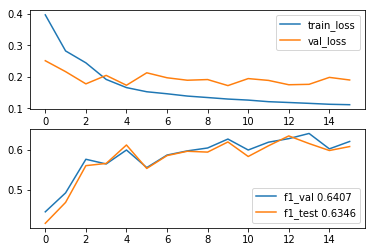

Epoch 17/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1090 - acc: 0.9618 - val_loss: 0.1872 - val_acc: 0.9362
— val_f1: 0.871392 — val_precision: 0.877161 — val_recall 0.865699
F1 all
0.8664246823956442
***
F1 angry: 
0.5576036866359446
****
F1 happy: 
0.6495176848874598
****
F1 others: 
0.923008455718736
****
F1 sad: 
0.6715867158671586
****
F1 happy angry sad
0.6161417322834646
#############
F1 test:
#############
F1 all
0.8714830277727353
***
F1 angry: 
0.5572609208972844
****
F1 happy: 
0.6219931271477662
****
F1 others: 
0.928263512766663
****
F1 sad: 
0.6826568265682655
****
F1 happy angry sad
0.6108574327752408


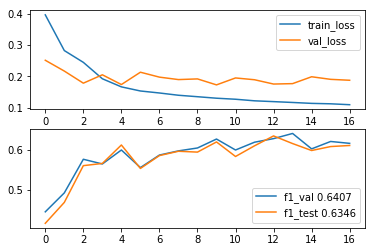

Epoch 18/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1071 - acc: 0.9622 - val_loss: 0.1969 - val_acc: 0.9330
— val_f1: 0.864815 — val_precision: 0.870541 — val_recall 0.859165
F1 all
0.8602540834845734
***
F1 angry: 
0.5870646766169152
****
F1 happy: 
0.6081871345029239
****
F1 others: 
0.9183262474826582
****
F1 sad: 
0.6464646464646464
****
F1 happy angry sad
0.610951008645533
#############
F1 test:
#############
F1 all
0.8638591395897621
***
F1 angry: 
0.5832290362953692
****
F1 happy: 
0.5960665658093797
****
F1 others: 
0.9228708561223349
****
F1 sad: 
0.6510851419031718
****
F1 happy angry sad
0.6070908207867897


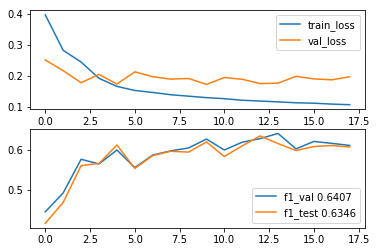

Epoch 19/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1059 - acc: 0.9626 - val_loss: 0.2102 - val_acc: 0.9273
— val_f1: 0.852603 — val_precision: 0.858088 — val_recall 0.847187
F1 all
0.8479128856624318
***
F1 angry: 
0.5333333333333332
****
F1 happy: 
0.6094182825484763
****
F1 others: 
0.9100768187980117
****
F1 sad: 
0.6666666666666666
****
F1 happy angry sad
0.5940959409594095
#############
F1 test:
#############
F1 all
0.8522417861680884
***
F1 angry: 
0.5369928400954653
****
F1 happy: 
0.5702127659574466
****
F1 others: 
0.9165170556552962
****
F1 sad: 
0.6571936056838364
****
F1 happy angry sad
0.5802469135802467


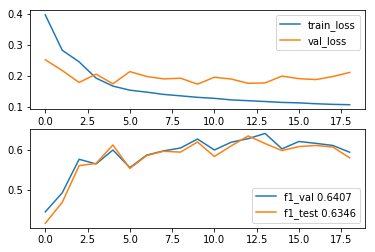

Epoch 20/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1044 - acc: 0.9630 - val_loss: 0.1955 - val_acc: 0.9343
— val_f1: 0.867263 — val_precision: 0.872520 — val_recall 0.862069
F1 all
0.8646098003629763
***
F1 angry: 
0.6077922077922077
****
F1 happy: 
0.6011235955056178
****
F1 others: 
0.921805183199285
****
F1 sad: 
0.6484641638225255
****
F1 happy angry sad
0.6170212765957446
#############
F1 test:
#############
F1 all
0.8656743510618986
***
F1 angry: 
0.5835475578406168
****
F1 happy: 
0.5852941176470587
****
F1 others: 
0.9242761692650333
****
F1 sad: 
0.6655172413793102
****
F1 happy angry sad
0.6074582924435721


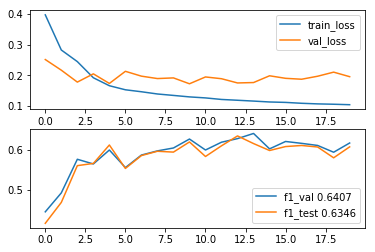

Epoch 21/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.1034 - acc: 0.9638 - val_loss: 0.2278 - val_acc: 0.9235
— val_f1: 0.844900 — val_precision: 0.852550 — val_recall 0.837387
F1 all
0.8395644283121596
***
F1 angry: 
0.5433789954337899
****
F1 happy: 
0.5775401069518715
****
F1 others: 
0.9051626108710483
****
F1 sad: 
0.6378737541528238
****
F1 happy angry sad
0.5804132973944293
#############
F1 test:
#############
F1 all
0.8449809402795424
***
F1 angry: 
0.5484247374562425
****
F1 happy: 
0.576502732240437
****
F1 others: 
0.9095853161114887
****
F1 sad: 
0.6467661691542287
****
F1 happy angry sad
0.58485401459854


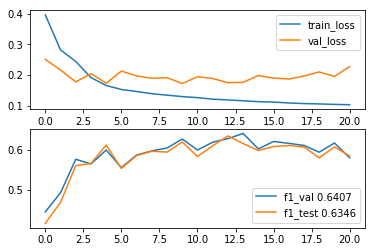

Epoch 22/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1030 - acc: 0.9639 - val_loss: 0.1992 - val_acc: 0.9344
— val_f1: 0.867883 — val_precision: 0.872661 — val_recall 0.863158
F1 all
0.8642468239564427
***
F1 angry: 
0.5599999999999999
****
F1 happy: 
0.6309148264984226
****
F1 others: 
0.9209177990643795
****
F1 sad: 
0.6810035842293907
****
F1 happy angry sad
0.6150832517140057
#############
F1 test:
#############
F1 all
0.8682156471228897
***
F1 angry: 
0.5645933014354065
****
F1 happy: 
0.6158833063209075
****
F1 others: 
0.9258272262935819
****
F1 sad: 
0.6726296958855097
****
F1 happy angry sad
0.6103379721669979


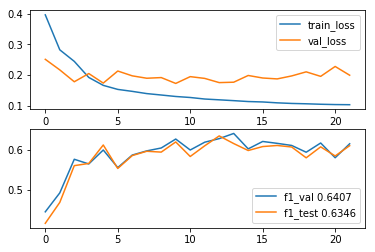

Epoch 23/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.1009 - acc: 0.9650 - val_loss: 0.2454 - val_acc: 0.9170
— val_f1: 0.831836 — val_precision: 0.840623 — val_recall 0.823230
F1 all
0.8243194192377494
***
F1 angry: 
0.5112474437627811
****
F1 happy: 
0.5966850828729281
****
F1 others: 
0.8942152569716523
****
F1 sad: 
0.6124999999999999
****
F1 happy angry sad
0.56532877882152
#############
F1 test:
#############
F1 all
0.8300962062080233
***
F1 angry: 
0.5063291139240506
****
F1 happy: 
0.5830903790087463
****
F1 others: 
0.9006061992451103
****
F1 sad: 
0.6115444617784711
****
F1 happy angry sad
0.5591208791208789


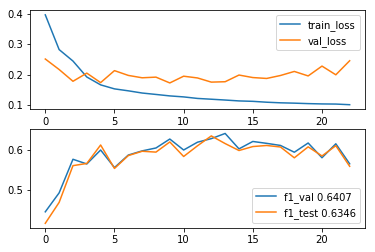

Epoch 24/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.0993 - acc: 0.9655 - val_loss: 0.1905 - val_acc: 0.9360
— val_f1: 0.869995 — val_precision: 0.876566 — val_recall 0.863521
F1 all
0.8646098003629763
***
F1 angry: 
0.578005115089514
****
F1 happy: 
0.598240469208211
****
F1 others: 
0.9220173294823372
****
F1 sad: 
0.6642599277978337
****
F1 happy angry sad
0.6085232903865211
#############
F1 test:
#############
F1 all
0.8703939008894536
***
F1 angry: 
0.5876288659793814
****
F1 happy: 
0.5898617511520736
****
F1 others: 
0.9275907883082372
****
F1 sad: 
0.665474060822898
****
F1 happy angry sad
0.6102719033232628


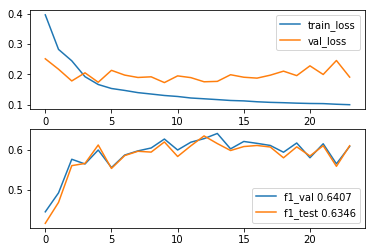

Epoch 25/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.0989 - acc: 0.9656 - val_loss: 0.2240 - val_acc: 0.9261
— val_f1: 0.851724 — val_precision: 0.855938 — val_recall 0.847550
F1 all
0.849364791288566
***
F1 angry: 
0.5784313725490196
****
F1 happy: 
0.5879120879120878
****
F1 others: 
0.9108553373956216
****
F1 sad: 
0.6319218241042344
****
F1 happy angry sad
0.5968489341983316
#############
F1 test:
#############
F1 all
0.8551461245235069
***
F1 angry: 
0.5783718104495746
****
F1 happy: 
0.5767575322812051
****
F1 others: 
0.9163203414579353
****
F1 sad: 
0.6487394957983192
****
F1 happy angry sad
0.5976359338061464


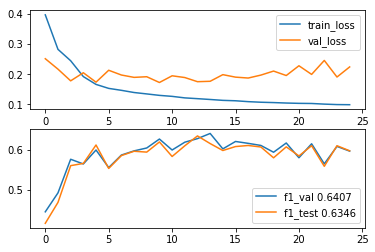

Epoch 26/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.0955 - acc: 0.9674 - val_loss: 0.2035 - val_acc: 0.9338
— val_f1: 0.867202 — val_precision: 0.871654 — val_recall 0.862795
F1 all
0.8649727767695099
***
F1 angry: 
0.5835543766578248
****
F1 happy: 
0.6028169014084506
****
F1 others: 
0.9210584834333999
****
F1 sad: 
0.6761565836298932
****
F1 happy angry sad
0.6159921026653503
#############
F1 test:
#############
F1 all
0.8665819567979669
***
F1 angry: 
0.5770750988142291
****
F1 happy: 
0.5787965616045844
****
F1 others: 
0.9243585471509497
****
F1 sad: 
0.6881720430107526
****
F1 happy angry sad
0.6084367245657567


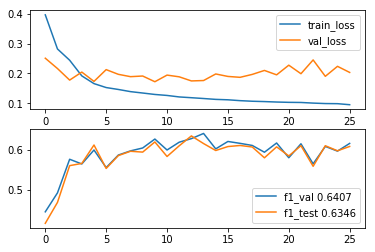

Epoch 27/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.0957 - acc: 0.9672 - val_loss: 0.2285 - val_acc: 0.9264
— val_f1: 0.852668 — val_precision: 0.855629 — val_recall 0.849728
F1 all
0.8504537205081668
***
F1 angry: 
0.560919540229885
****
F1 happy: 
0.599439775910364
****
F1 others: 
0.9121697900203205
****
F1 sad: 
0.6505190311418684
****
F1 happy angry sad
0.5975948196114708
#############
F1 test:
#############
F1 all
0.8480667997821745
***
F1 angry: 
0.5454545454545454
****
F1 happy: 
0.5599999999999998
****
F1 others: 
0.9129162916291628
****
F1 sad: 
0.6468531468531468
****
F1 happy angry sad
0.5774647887323943


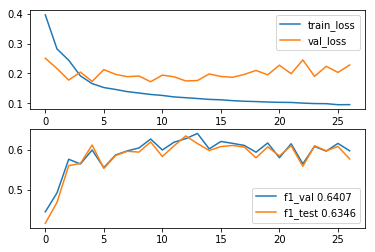

Epoch 28/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.0959 - acc: 0.9667 - val_loss: 0.2199 - val_acc: 0.9288
— val_f1: 0.856934 — val_precision: 0.861651 — val_recall 0.852269
F1 all
0.8533575317604355
***
F1 angry: 
0.5454545454545453
****
F1 happy: 
0.6623376623376622
****
F1 others: 
0.9140414041404139
****
F1 sad: 
0.6163522012578616
****
F1 happy angry sad
0.6003752345215758
#############
F1 test:
#############
F1 all
0.8573243782900707
***
F1 angry: 
0.5458823529411764
****
F1 happy: 
0.6095890410958903
****
F1 others: 
0.9190757897086727
****
F1 sad: 
0.6271999999999999
****
F1 happy angry sad
0.5886352598348712


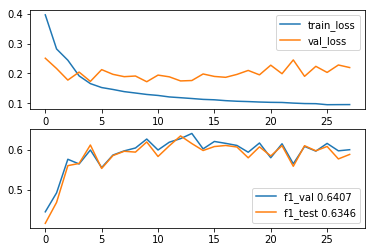

Epoch 29/100
30160/30160 [==============================] - 191s 6ms/step - loss: 0.0933 - acc: 0.9682 - val_loss: 0.2124 - val_acc: 0.9315
— val_f1: 0.861263 — val_precision: 0.866324 — val_recall 0.856261
F1 all
0.8573502722323048
***
F1 angry: 
0.5737265415549596
****
F1 happy: 
0.6306306306306305
****
F1 others: 
0.9175418994413407
****
F1 sad: 
0.5896656534954406
****
F1 happy angry sad
0.5971014492753622
#############
F1 test:
#############
F1 all
0.8558722091123615
***
F1 angry: 
0.5766710353866317
****
F1 happy: 
0.5829457364341085
****
F1 others: 
0.9175787357605538
****
F1 sad: 
0.6067073170731706
****
F1 happy angry sad
0.5881782945736433


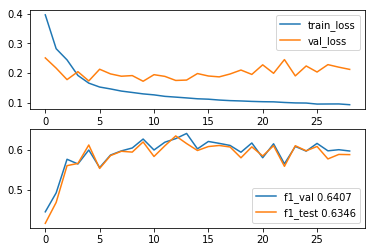

Epoch 30/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.0925 - acc: 0.9683 - val_loss: 0.2170 - val_acc: 0.9299
— val_f1: 0.858965 — val_precision: 0.862422 — val_recall 0.855535
F1 all
0.8562613430127041
***
F1 angry: 
0.5632458233890214
****
F1 happy: 
0.6022099447513811
****
F1 others: 
0.9168347904057386
****
F1 sad: 
0.6492537313432835
****
F1 happy angry sad
0.5986653956148712
#############
F1 test:
#############
F1 all
0.8589580686149936
***
F1 angry: 
0.553956834532374
****
F1 happy: 
0.5755395683453236
****
F1 others: 
0.9196428571428571
****
F1 sad: 
0.6843100189035916
****
F1 happy angry sad
0.5947521865889213


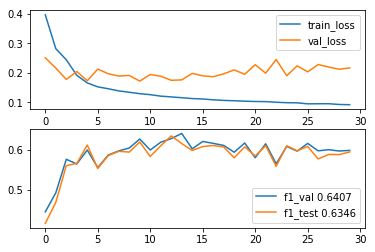

Epoch 31/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.0912 - acc: 0.9684 - val_loss: 0.2580 - val_acc: 0.9186
— val_f1: 0.835559 — val_precision: 0.842183 — val_recall 0.829038
F1 all
0.8301270417422866
***
F1 angry: 
0.5178571428571428
****
F1 happy: 
0.5927977839335179
****
F1 others: 
0.898835350536652
****
F1 sad: 
0.5962732919254657
****
F1 happy angry sad
0.564102564102564
#############
F1 test:
#############
F1 all
0.8331820657106552
***
F1 angry: 
0.5336322869955156
****
F1 happy: 
0.5550786838340486
****
F1 others: 
0.9020501138952163
****
F1 sad: 
0.6120556414219473
****
F1 happy angry sad
0.5630026809651474


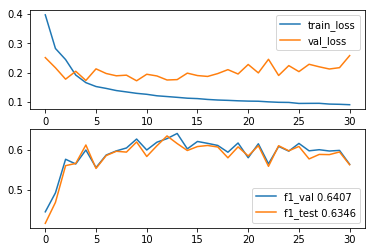

Epoch 32/100
30160/30160 [==============================] - 191s 6ms/step - loss: 0.0905 - acc: 0.9694 - val_loss: 0.2323 - val_acc: 0.9240
— val_f1: 0.847235 — val_precision: 0.852056 — val_recall 0.842468
F1 all
0.843557168784029
***
F1 angry: 
0.5679012345679012
****
F1 happy: 
0.5445544554455445
****
F1 others: 
0.909008805599458
****
F1 sad: 
0.6323529411764705
****
F1 happy angry sad
0.5753931544865863
#############
F1 test:
#############
F1 all
0.8480667997821745
***
F1 angry: 
0.5873417721518986
****
F1 happy: 
0.523153942428035
****
F1 others: 
0.9123873873873873
****
F1 sad: 
0.6557377049180326
****
F1 happy angry sad
0.5809167446211411


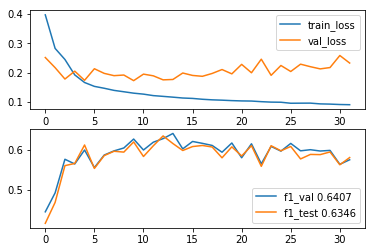

Epoch 33/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.0905 - acc: 0.9690 - val_loss: 0.2232 - val_acc: 0.9296
— val_f1: 0.858289 — val_precision: 0.862537 — val_recall 0.854083
F1 all
0.8551724137931034
***
F1 angry: 
0.55188679245283
****
F1 happy: 
0.636085626911315
****
F1 others: 
0.915695067264574
****
F1 sad: 
0.6220735785953175
****
F1 happy angry sad
0.5980952380952379
#############
F1 test:
#############
F1 all
0.8614993646759846
***
F1 angry: 
0.5602923264311813
****
F1 happy: 
0.5999999999999999
****
F1 others: 
0.9212580861030558
****
F1 sad: 
0.6565143824027072
****
F1 happy angry sad
0.6003898635477583


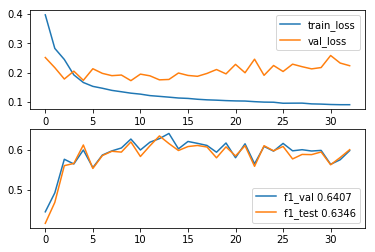

Epoch 34/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.0890 - acc: 0.9700 - val_loss: 0.2685 - val_acc: 0.9187
— val_f1: 0.836403 — val_precision: 0.840543 — val_recall 0.832305
F1 all
0.8330308529945553
***
F1 angry: 
0.5061224489795917
****
F1 happy: 
0.5917159763313609
****
F1 others: 
0.9012738853503184
****
F1 sad: 
0.6293706293706293
****
F1 happy angry sad
0.563734290843806
#############
F1 test:
#############
F1 all
0.8404429115992011
***
F1 angry: 
0.512169312169312
****
F1 happy: 
0.5778443113772453
****
F1 others: 
0.9069293478260868
****
F1 sad: 
0.6631762652705061
****
F1 happy angry sad
0.5718206770356815


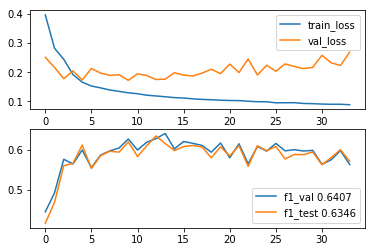

Epoch 35/100
25344/30160 [========================>.....] - ETA: 27s - loss: 0.0883 - acc: 0.9699

In [0]:
model.fit([train[TURNS_NAMES[i]] for i in range(3)], Y_train, epochs=100, verbose=1,
          batch_size=128,
          validation_data=([dev[TURNS_NAMES[i]] for i in range(3)], Y_dev),
          callbacks= [ Metrics([test[TURNS_NAMES[i]] for i in range(3)], Y_test, 3),
                    ])

### concat

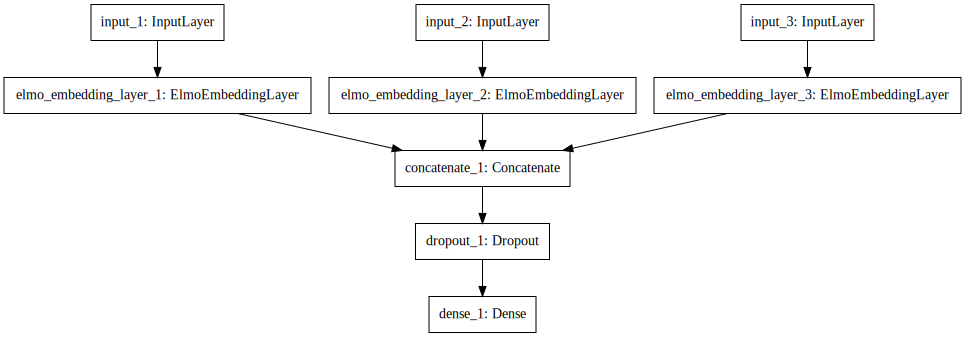

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### ELMO concat

Train on 30160 samples, validate on 2755 samples
Epoch 1/100
30160/30160 [==============================] - 196s 6ms/step - loss: 0.4670 - acc: 0.8290 - val_loss: 0.1905 - val_acc: 0.9372
— val_f1: 0.866335 — val_precision: 0.916903 — val_recall 0.821053
F1 all
0.8323049001814881
***
F1 angry: 
0.3985765124555159
****
F1 happy: 
0.5813953488372092
****
F1 others: 
0.9111310592459603
****
F1 sad: 
0.6495726495726495
****
F1 happy angry sad
0.49905123339658425
#############
F1 test:
#############
F1 all
0.8231984026139044
***
F1 angry: 
0.3842869342442356
****
F1 happy: 
0.5510204081632651
****
F1 others: 
0.9094992140130248
****
F1 sad: 
0.5543237250554323
****
F1 happy angry sad
0.4592803030303029


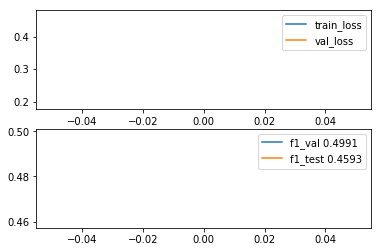

Epoch 2/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.3094 - acc: 0.8699 - val_loss: 0.1888 - val_acc: 0.9338
— val_f1: 0.855389 — val_precision: 0.906873 — val_recall 0.809437
F1 all
0.8185117967332123
***
F1 angry: 
0.38741721854304634
****
F1 happy: 
0.5779467680608364
****
F1 others: 
0.9000454338936845
****
F1 sad: 
0.6721991701244813
****
F1 happy angry sad
0.4945848375451263
#############
F1 test:
#############
F1 all
0.8201125431112724
***
F1 angry: 
0.3889354568315171
****
F1 happy: 
0.5674044265593561
****
F1 others: 
0.9050582776960506
****
F1 sad: 
0.5947046843177187
****
F1 happy angry sad
0.47592847317744147


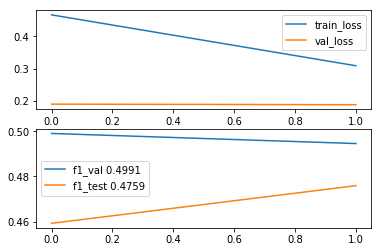

Epoch 3/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2943 - acc: 0.8767 - val_loss: 0.1875 - val_acc: 0.9370
— val_f1: 0.862828 — val_precision: 0.912217 — val_recall 0.818512
F1 all
0.8308529945553538
***
F1 angry: 
0.4285714285714285
****
F1 happy: 
0.588235294117647
****
F1 others: 
0.9072398190045248
****
F1 sad: 
0.6639344262295082
****
F1 happy angry sad
0.5211009174311926
#############
F1 test:
#############
F1 all
0.8290070793247413
***
F1 angry: 
0.41480206540447495
****
F1 happy: 
0.5984555984555984
****
F1 others: 
0.9088650479954826
****
F1 sad: 
0.6086956521739129
****
F1 happy angry sad
0.5020804438280165


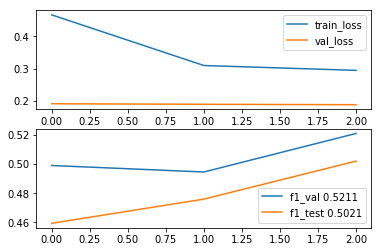

Epoch 4/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2862 - acc: 0.8798 - val_loss: 0.1834 - val_acc: 0.9373
— val_f1: 0.865586 — val_precision: 0.911647 — val_recall 0.823956
F1 all
0.8359346642468238
***
F1 angry: 
0.4331450094161957
****
F1 happy: 
0.6195286195286194
****
F1 others: 
0.9078174423859013
****
F1 sad: 
0.6796874999999998
****
F1 happy angry sad
0.5424354243542434
#############
F1 test:
#############
F1 all
0.835360319477219
***
F1 angry: 
0.4272030651340995
****
F1 happy: 
0.5950704225352111
****
F1 others: 
0.9102982554867753
****
F1 sad: 
0.637236084452975
****
F1 happy angry sad
0.5232067510548521


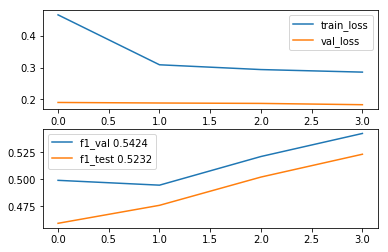

Epoch 5/100
30160/30160 [==============================] - 187s 6ms/step - loss: 0.2827 - acc: 0.8809 - val_loss: 0.1789 - val_acc: 0.9361
— val_f1: 0.867625 — val_precision: 0.905645 — val_recall 0.832668
F1 all
0.8446460980036297
***
F1 angry: 
0.45991561181434587
****
F1 happy: 
0.6176470588235293
****
F1 others: 
0.9142343960484957
****
F1 sad: 
0.6322580645161289
****
F1 happy angry sad
0.5511363636363635
#############
F1 test:
#############
F1 all
0.842076601924124
***
F1 angry: 
0.4508547008547008
****
F1 happy: 
0.6091954022988505
****
F1 others: 
0.9149960801881508
****
F1 sad: 
0.5832012678288429
****
F1 happy angry sad
0.5303973192915269


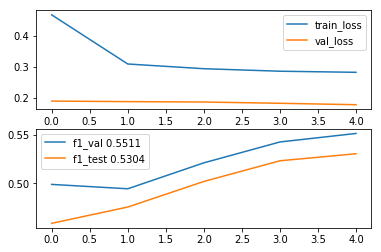

Epoch 6/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2820 - acc: 0.8833 - val_loss: 0.1738 - val_acc: 0.9406
— val_f1: 0.875520 — val_precision: 0.914263 — val_recall 0.839927
F1 all
0.8457350272232304
***
F1 angry: 
0.44241316270566716
****
F1 happy: 
0.5843621399176954
****
F1 others: 
0.9176523097522873
****
F1 sad: 
0.6861924686192467
****
F1 happy angry sad
0.5325558794946549
#############
F1 test:
#############
F1 all
0.8446178979851151
***
F1 angry: 
0.43462246777163904
****
F1 happy: 
0.5749999999999998
****
F1 others: 
0.9194608443800825
****
F1 sad: 
0.6399999999999999
****
F1 happy angry sad
0.5154336109750122


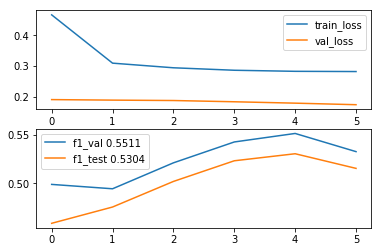

Epoch 7/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2778 - acc: 0.8835 - val_loss: 0.1908 - val_acc: 0.9290
— val_f1: 0.850862 — val_precision: 0.890167 — val_recall 0.814882
F1 all
0.8206896551724137
***
F1 angry: 
0.41681260945709275
****
F1 happy: 
0.6163522012578615
****
F1 others: 
0.8964097873313512
****
F1 sad: 
0.6774193548387096
****
F1 happy angry sad
0.5294635004397537
#############
F1 test:
#############
F1 all
0.8242875294971863
***
F1 angry: 
0.42375886524822687
****
F1 happy: 
0.5960912052117263
****
F1 others: 
0.9019920318725098
****
F1 sad: 
0.6395112016293278
****
F1 happy angry sad
0.5185848634124495


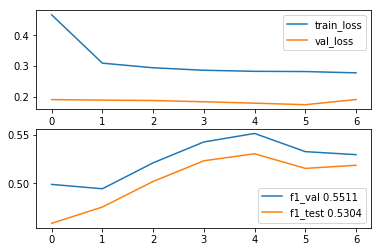

Epoch 8/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2755 - acc: 0.8846 - val_loss: 0.1682 - val_acc: 0.9434
— val_f1: 0.880813 — val_precision: 0.915102 — val_recall 0.849002
F1 all
0.8551724137931034
***
F1 angry: 
0.4488977955911822
****
F1 happy: 
0.6206896551724136
****
F1 others: 
0.9213732004429679
****
F1 sad: 
0.7063829787234042
****
F1 happy angry sad
0.5547738693467335
#############
F1 test:
#############
F1 all
0.8542385187874386
***
F1 angry: 
0.4503441494591936
****
F1 happy: 
0.5992063492063491
****
F1 others: 
0.9238432588000884
****
F1 sad: 
0.6609071274298055
****
F1 happy angry sad
0.537298387096774


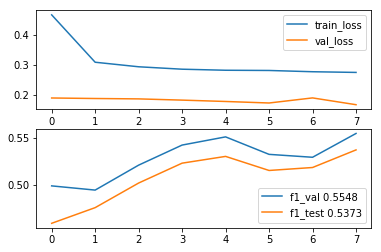

Epoch 9/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2760 - acc: 0.8843 - val_loss: 0.1845 - val_acc: 0.9338
— val_f1: 0.860980 — val_precision: 0.898894 — val_recall 0.826134
F1 all
0.831578947368421
***
F1 angry: 
0.42808219178082185
****
F1 happy: 
0.6458333333333333
****
F1 others: 
0.9042528997043439
****
F1 sad: 
0.7053941908713691
****
F1 happy angry sad
0.5444743935309972
#############
F1 test:
#############
F1 all
0.8302777273552367
***
F1 angry: 
0.42519685039370075
****
F1 happy: 
0.5896980461811722
****
F1 others: 
0.9073822463768114
****
F1 sad: 
0.6583333333333331
****
F1 happy angry sad
0.5187557182067702


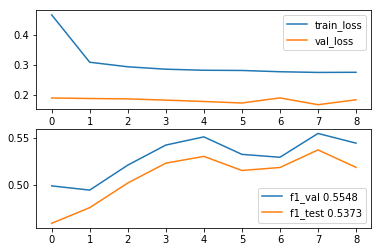

Epoch 10/100
30160/30160 [==============================] - 191s 6ms/step - loss: 0.2750 - acc: 0.8864 - val_loss: 0.1645 - val_acc: 0.9445
— val_f1: 0.884167 — val_precision: 0.917284 — val_recall 0.853358
F1 all
0.8617059891107077
***
F1 angry: 
0.48547717842323646
****
F1 happy: 
0.6125461254612545
****
F1 others: 
0.924712134632418
****
F1 sad: 
0.7136929460580911
****
F1 happy angry sad
0.5754527162977866
#############
F1 test:
#############
F1 all
0.8580504628789253
***
F1 angry: 
0.4667349027635618
****
F1 happy: 
0.588007736943907
****
F1 others: 
0.9268454154253558
****
F1 sad: 
0.6377440347071581
****
F1 happy angry sad
0.5391304347826087


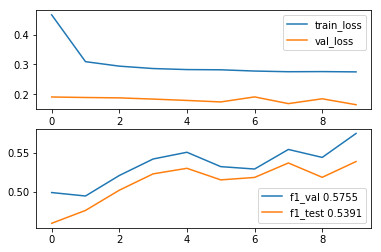

Epoch 11/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2748 - acc: 0.8856 - val_loss: 0.1669 - val_acc: 0.9430
— val_f1: 0.881056 — val_precision: 0.916471 — val_recall 0.848276
F1 all
0.858076225045372
***
F1 angry: 
0.4628099173553718
****
F1 happy: 
0.6304347826086956
****
F1 others: 
0.9224272060457879
****
F1 sad: 
0.7171314741035856
****
F1 happy angry sad
0.5717111770524234
#############
F1 test:
#############
F1 all
0.8549646033762932
***
F1 angry: 
0.47169811320754707
****
F1 happy: 
0.5906542056074765
****
F1 others: 
0.923008751523208
****
F1 sad: 
0.641434262948207
****
F1 happy angry sad
0.5464590657960823


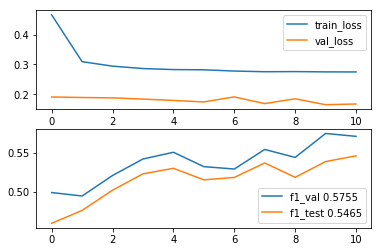

Epoch 12/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2730 - acc: 0.8868 - val_loss: 0.1770 - val_acc: 0.9387
— val_f1: 0.872075 — val_precision: 0.908055 — val_recall 0.838838
F1 all
0.8446460980036297
***
F1 angry: 
0.44808743169398896
****
F1 happy: 
0.6254545454545453
****
F1 others: 
0.9145164909131701
****
F1 sad: 
0.6986899563318776
****
F1 happy angry sad
0.5489078822412156
#############
F1 test:
#############
F1 all
0.846796151751679
***
F1 angry: 
0.44670991658943465
****
F1 happy: 
0.612781954887218
****
F1 others: 
0.9195171026156941
****
F1 sad: 
0.6420824295010845
****
F1 happy angry sad
0.5328185328185328


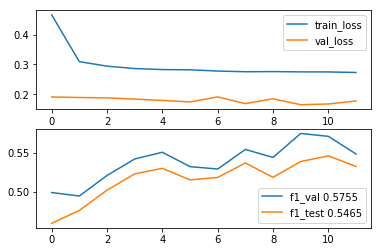

Epoch 13/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2714 - acc: 0.8876 - val_loss: 0.1685 - val_acc: 0.9403
— val_f1: 0.875778 — val_precision: 0.910980 — val_recall 0.843194
F1 all
0.8533575317604355
***
F1 angry: 
0.48508946322067586
****
F1 happy: 
0.6366782006920414
****
F1 others: 
0.9183627823753073
****
F1 sad: 
0.6801619433198379
****
F1 happy angry sad
0.573628488931665
#############
F1 test:
#############
F1 all
0.8533309130513703
***
F1 angry: 
0.46680080482897374
****
F1 happy: 
0.6018348623853209
****
F1 others: 
0.9227691965773974
****
F1 sad: 
0.6374999999999998
****
F1 happy angry sad
0.5438335809806835


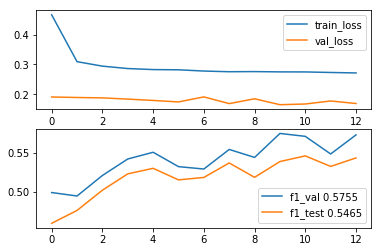

Epoch 14/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2728 - acc: 0.8867 - val_loss: 0.1746 - val_acc: 0.9393
— val_f1: 0.873043 — val_precision: 0.908877 — val_recall 0.839927
F1 all
0.8482758620689654
***
F1 angry: 
0.47378640776699016
****
F1 happy: 
0.6329966329966329
****
F1 others: 
0.9150414705223042
****
F1 sad: 
0.6751054852320675
****
F1 happy angry sad
0.5643469971401334
#############
F1 test:
#############
F1 all
0.8462515883100381
***
F1 angry: 
0.456921587608906
****
F1 happy: 
0.59245960502693
****
F1 others: 
0.9190577202188231
****
F1 sad: 
0.6157112526539277
****
F1 happy angry sad
0.5298398835516739


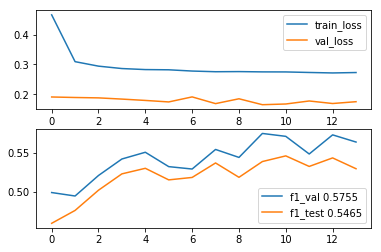

Epoch 15/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2712 - acc: 0.8867 - val_loss: 0.1775 - val_acc: 0.9371
— val_f1: 0.868252 — val_precision: 0.904444 — val_recall 0.834846
F1 all
0.843557168784029
***
F1 angry: 
0.4627151051625238
****
F1 happy: 
0.6326530612244897
****
F1 others: 
0.911181244364292
****
F1 sad: 
0.6926070038910505
****
F1 happy angry sad
0.5642458100558657
#############
F1 test:
#############
F1 all
0.8444363768379015
***
F1 angry: 
0.46334310850439875
****
F1 happy: 
0.6054054054054052
****
F1 others: 
0.9152542372881355
****
F1 sad: 
0.6403013182674199
****
F1 happy angry sad
0.5452821242294925


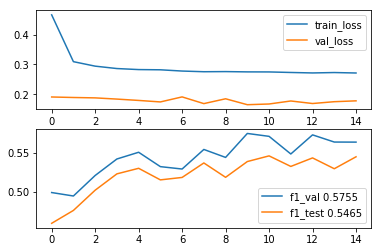

Epoch 16/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2714 - acc: 0.8883 - val_loss: 0.1820 - val_acc: 0.9356
— val_f1: 0.865479 — val_precision: 0.905272 — val_recall 0.829038
F1 all
0.8373865698729581
***
F1 angry: 
0.445632798573975
****
F1 happy: 
0.6341463414634146
****
F1 others: 
0.9074869938927843
****
F1 sad: 
0.7053941908713691
****
F1 happy angry sad
0.5528007346189163
#############
F1 test:
#############
F1 all
0.8377200943909965
***
F1 angry: 
0.43960036330608526
****
F1 happy: 
0.5901639344262294
****
F1 others: 
0.9129798491500618
****
F1 sad: 
0.6432989690721648
****
F1 happy angry sad
0.524590163934426


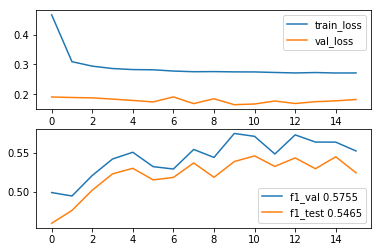

Epoch 17/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2686 - acc: 0.8890 - val_loss: 0.1677 - val_acc: 0.9397
— val_f1: 0.874976 — val_precision: 0.910518 — val_recall 0.842105
F1 all
0.849364791288566
***
F1 angry: 
0.466019417475728
****
F1 happy: 
0.6258992805755395
****
F1 others: 
0.9160714285714284
****
F1 sad: 
0.6835443037974682
****
F1 happy angry sad
0.5592233009708737
#############
F1 test:
#############
F1 all
0.8487928843710291
***
F1 angry: 
0.44847328244274803
****
F1 happy: 
0.6068702290076334
****
F1 others: 
0.9206950323011805
****
F1 sad: 
0.6367521367521367
****
F1 happy angry sad
0.5323529411764705


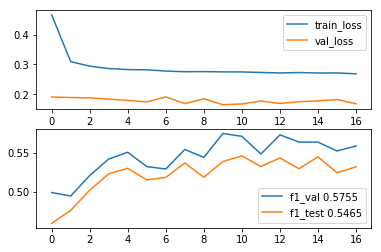

Epoch 18/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2696 - acc: 0.8880 - val_loss: 0.1705 - val_acc: 0.9408
— val_f1: 0.877325 — val_precision: 0.909268 — val_recall 0.847550
F1 all
0.8548094373865698
***
F1 angry: 
0.47272727272727266
****
F1 happy: 
0.644927536231884
****
F1 others: 
0.9189189189189189
****
F1 sad: 
0.7022900763358778
****
F1 happy angry sad
0.5769603097773475
#############
F1 test:
#############
F1 all
0.8511526592848065
***
F1 angry: 
0.4643216080402009
****
F1 happy: 
0.6098484848484848
****
F1 others: 
0.9201605709188224
****
F1 sad: 
0.6489563567362427
****
F1 happy angry sad
0.5492682926829268


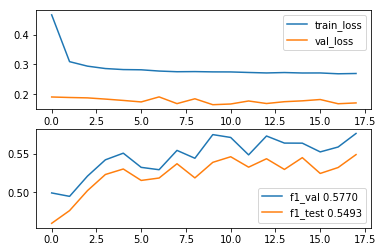

Epoch 19/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2714 - acc: 0.8874 - val_loss: 0.1666 - val_acc: 0.9437
— val_f1: 0.882730 — val_precision: 0.918399 — val_recall 0.849728
F1 all
0.8617059891107077
***
F1 angry: 
0.4908722109533469
****
F1 happy: 
0.6379928315412186
****
F1 others: 
0.9236250278334446
****
F1 sad: 
0.728744939271255
****
F1 happy angry sad
0.5888125613346417
#############
F1 test:
#############
F1 all
0.857142857142857
***
F1 angry: 
0.47265221878224956
****
F1 happy: 
0.6091743119266054
****
F1 others: 
0.9242205702873626
****
F1 sad: 
0.659877800407332
****
F1 happy angry sad
0.5556109725685785


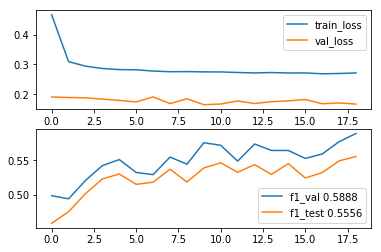

Epoch 20/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2696 - acc: 0.8871 - val_loss: 0.1699 - val_acc: 0.9456
— val_f1: 0.886617 — val_precision: 0.926424 — val_recall 0.850091
F1 all
0.8606170598911069
***
F1 angry: 
0.4562118126272911
****
F1 happy: 
0.5689655172413792
****
F1 others: 
0.9284774023694602
****
F1 sad: 
0.6724890829694322
****
F1 happy angry sad
0.5357142857142856
#############
F1 test:
#############
F1 all
0.858231984026139
***
F1 angry: 
0.440881763527054
****
F1 happy: 
0.5446428571428571
****
F1 others: 
0.9302070779007339
****
F1 sad: 
0.6337078651685392
****
F1 happy angry sad
0.5108408249603382


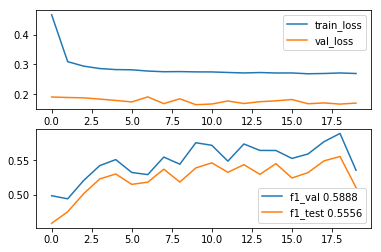

Epoch 21/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2698 - acc: 0.8875 - val_loss: 0.1638 - val_acc: 0.9437
— val_f1: 0.883677 — val_precision: 0.914563 — val_recall 0.854809
F1 all
0.8627949183303084
***
F1 angry: 
0.48861283643892334
****
F1 happy: 
0.6223776223776223
****
F1 others: 
0.9264836138175375
****
F1 sad: 
0.6933333333333334
****
F1 happy angry sad
0.573440643863179
#############
F1 test:
#############
F1 all
0.8627700127064802
***
F1 angry: 
0.48503611971104227
****
F1 happy: 
0.6167883211678831
****
F1 others: 
0.9276003094948599
****
F1 sad: 
0.674008810572687
****
F1 happy angry sad
0.5651953323186198


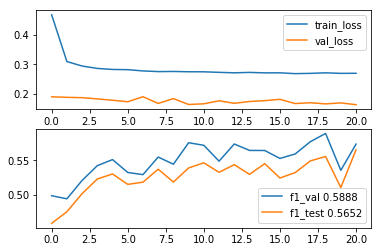

Epoch 22/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2696 - acc: 0.8883 - val_loss: 0.1687 - val_acc: 0.9402
— val_f1: 0.875822 — val_precision: 0.907710 — val_recall 0.846098
F1 all
0.8544464609800362
***
F1 angry: 
0.49480249480249466
****
F1 happy: 
0.6249999999999999
****
F1 others: 
0.9186410371032633
****
F1 sad: 
0.6772908366533865
****
F1 happy angry sad
0.5772200772200771
#############
F1 test:
#############
F1 all
0.8500635324015247
***
F1 angry: 
0.4670157068062826
****
F1 happy: 
0.5962521294718908
****
F1 others: 
0.9192560418754872
****
F1 sad: 
0.6358148893360159
****
F1 happy angry sad
0.5453653751839136


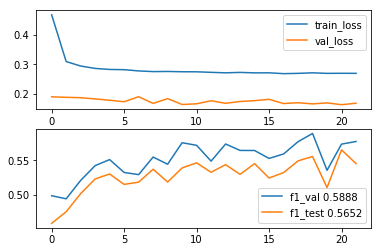

Epoch 23/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2690 - acc: 0.8882 - val_loss: 0.1779 - val_acc: 0.9377
— val_f1: 0.870009 — val_precision: 0.908696 — val_recall 0.834483
F1 all
0.843557168784029
***
F1 angry: 
0.4540337711069418
****
F1 happy: 
0.6456140350877192
****
F1 others: 
0.9114724480578138
****
F1 sad: 
0.7045454545454544
****
F1 happy angry sad
0.565619223659889
#############
F1 test:
#############
F1 all
0.8438918133962606
***
F1 angry: 
0.45977011494252856
****
F1 happy: 
0.6112115732368896
****
F1 others: 
0.9148123173746908
****
F1 sad: 
0.650095602294455
****
F1 happy angry sad
0.5462264150943394


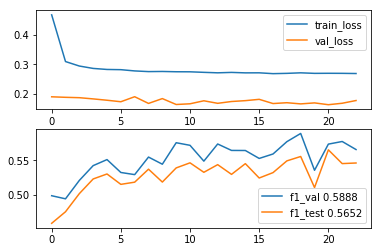

Epoch 24/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2701 - acc: 0.8881 - val_loss: 0.1811 - val_acc: 0.9366
— val_f1: 0.867324 — val_precision: 0.907576 — val_recall 0.830490
F1 all
0.8406533575317603
***
F1 angry: 
0.4482109227871939
****
F1 happy: 
0.6319444444444444
****
F1 others: 
0.9092960288808664
****
F1 sad: 
0.7027027027027026
****
F1 happy angry sad
0.5584415584415583
#############
F1 test:
#############
F1 all
0.8442548556906878
***
F1 angry: 
0.46094503375120527
****
F1 happy: 
0.6021897810218978
****
F1 others: 
0.9158249158249158
****
F1 sad: 
0.6386233269598469
****
F1 happy angry sad
0.5417457305502844


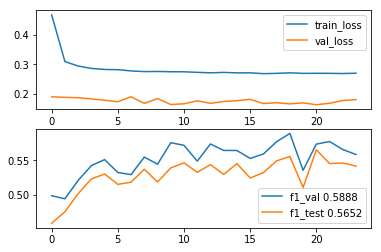

Epoch 25/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2694 - acc: 0.8889 - val_loss: 0.1494 - val_acc: 0.9495
— val_f1: 0.896075 — val_precision: 0.923699 — val_recall 0.870054
F1 all
0.8773139745916514
***
F1 angry: 
0.49427917620137285
****
F1 happy: 
0.5999999999999999
****
F1 others: 
0.936225596529284
****
F1 sad: 
0.7085201793721972
****
F1 happy angry sad
0.5755555555555555
#############
F1 test:
#############
F1 all
0.8709384643310945
***
F1 angry: 
0.4881355932203389
****
F1 happy: 
0.5779625779625779
****
F1 others: 
0.9349549353892931
****
F1 sad: 
0.6230248306997742
****
F1 happy angry sad
0.5450525152017688


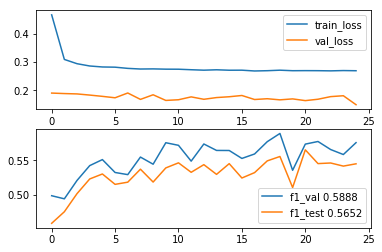

Epoch 26/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2683 - acc: 0.8873 - val_loss: 0.1727 - val_acc: 0.9412
— val_f1: 0.878168 — val_precision: 0.909409 — val_recall 0.849002
F1 all
0.8540834845735026
***
F1 angry: 
0.4666666666666665
****
F1 happy: 
0.6428571428571427
****
F1 others: 
0.9180254634800088
****
F1 sad: 
0.7325102880658435
****
F1 happy angry sad
0.5769603097773475
#############
F1 test:
#############
F1 all
0.852967870756943
***
F1 angry: 
0.4639684106614017
****
F1 happy: 
0.6128440366972475
****
F1 others: 
0.9213282817026965
****
F1 sad: 
0.6707818930041151
****
F1 happy angry sad
0.5528375733855184


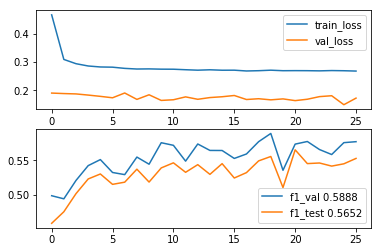

Epoch 27/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2688 - acc: 0.8883 - val_loss: 0.1689 - val_acc: 0.9424
— val_f1: 0.880769 — val_precision: 0.915427 — val_recall 0.848639
F1 all
0.8577132486388384
***
F1 angry: 
0.4779116465863452
****
F1 happy: 
0.633093525179856
****
F1 others: 
0.9204368174726988
****
F1 sad: 
0.7368421052631579
****
F1 happy angry sad
0.5826001955034211
#############
F1 test:
#############
F1 all
0.8567798148484297
***
F1 angry: 
0.4720244150559511
****
F1 happy: 
0.6165413533834586
****
F1 others: 
0.9236921026324557
****
F1 sad: 
0.6639999999999999
****
F1 happy angry sad
0.5578163771712158


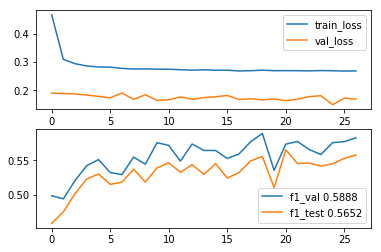

Epoch 28/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2691 - acc: 0.8882 - val_loss: 0.1680 - val_acc: 0.9404
— val_f1: 0.876553 — val_precision: 0.910121 — val_recall 0.845372
F1 all
0.8548094373865698
***
F1 angry: 
0.48207171314741026
****
F1 happy: 
0.635379061371841
****
F1 others: 
0.9184721911994639
****
F1 sad: 
0.7086614173228345
****
F1 happy angry sad
0.5788964181994191
#############
F1 test:
#############
F1 all
0.853512434198584
***
F1 angry: 
0.46414342629482064
****
F1 happy: 
0.6068702290076334
****
F1 others: 
0.9227004782560336
****
F1 sad: 
0.6492985971943886
****
F1 happy angry sad
0.546620621608288


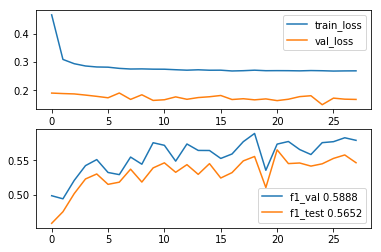

Epoch 29/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2674 - acc: 0.8893 - val_loss: 0.1739 - val_acc: 0.9382
— val_f1: 0.871515 — val_precision: 0.905993 — val_recall 0.839564
F1 all
0.8479128856624318
***
F1 angry: 
0.47169811320754707
****
F1 happy: 
0.6241134751773048
****
F1 others: 
0.9154295996401258
****
F1 sad: 
0.6984126984126984
****
F1 happy angry sad
0.5657894736842105
#############
F1 test:
#############
F1 all
0.8460700671628245
***
F1 angry: 
0.4516129032258064
****
F1 happy: 
0.6104868913857676
****
F1 others: 
0.9178235557545901
****
F1 sad: 
0.646586345381526
****
F1 happy angry sad
0.5388302972195589


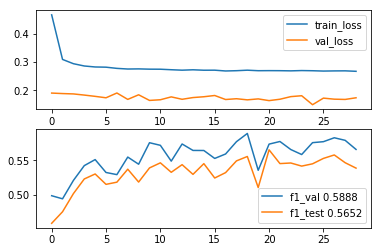

Epoch 30/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2692 - acc: 0.8890 - val_loss: 0.1706 - val_acc: 0.9409
— val_f1: 0.877505 — val_precision: 0.915582 — val_recall 0.842468
F1 all
0.8519056261343012
***
F1 angry: 
0.46918489065606356
****
F1 happy: 
0.6391752577319587
****
F1 others: 
0.9176733780760624
****
F1 sad: 
0.6910569105691056
****
F1 happy angry sad
0.5692307692307691
#############
F1 test:
#############
F1 all
0.8536939553457977
***
F1 angry: 
0.46502057613168707
****
F1 happy: 
0.6017699115044247
****
F1 others: 
0.9225469496610733
****
F1 sad: 
0.6473029045643153
****
F1 happy angry sad
0.5468053491827636


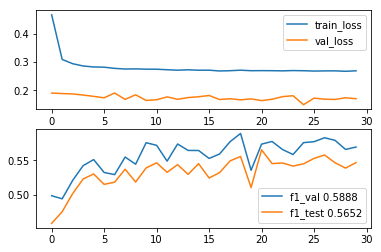

Epoch 31/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2703 - acc: 0.8885 - val_loss: 0.1779 - val_acc: 0.9384
— val_f1: 0.871610 — val_precision: 0.912629 — val_recall 0.834120
F1 all
0.8442831215970961
***
F1 angry: 
0.45778611632270166
****
F1 happy: 
0.6228373702422144
****
F1 others: 
0.913063063063063
****
F1 sad: 
0.7016129032258063
****
F1 happy angry sad
0.5588785046728971
#############
F1 test:
#############
F1 all
0.8438918133962606
***
F1 angry: 
0.44866920152091244
****
F1 happy: 
0.6054054054054052
****
F1 others: 
0.9158815612382234
****
F1 sad: 
0.6545454545454544
****
F1 happy angry sad
0.5385347288296859


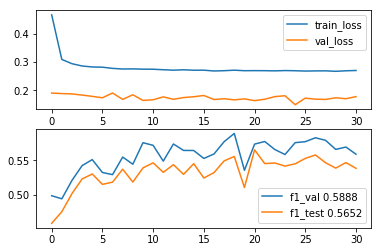

Epoch 32/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2682 - acc: 0.8891 - val_loss: 0.1630 - val_acc: 0.9427
— val_f1: 0.881813 — val_precision: 0.910991 — val_recall 0.854446
F1 all
0.8642468239564427
***
F1 angry: 
0.5098039215686273
****
F1 happy: 
0.6548042704626333
****
F1 others: 
0.9236912156166813
****
F1 sad: 
0.6870229007633586
****
F1 happy angry sad
0.5968063872255487
#############
F1 test:
#############
F1 all
0.8585950263205663
***
F1 angry: 
0.47720042417815467
****
F1 happy: 
0.601134215500945
****
F1 others: 
0.9259546209186497
****
F1 sad: 
0.6379647749510763
****
F1 happy angry sad
0.5516893595562279


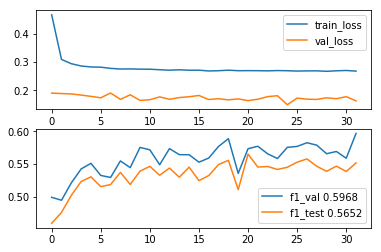

Epoch 33/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2668 - acc: 0.8881 - val_loss: 0.1676 - val_acc: 0.9430
— val_f1: 0.881465 — val_precision: 0.918207 — val_recall 0.847550
F1 all
0.8569872958257713
***
F1 angry: 
0.46825396825396814
****
F1 happy: 
0.6240601503759396
****
F1 others: 
0.9224272060457879
****
F1 sad: 
0.7053941908713691
****
F1 happy angry sad
0.5657764589515331
#############
F1 test:
#############
F1 all
0.8591395897622072
***
F1 angry: 
0.4709480122324158
****
F1 happy: 
0.5937499999999998
****
F1 others: 
0.9268886185156507
****
F1 sad: 
0.6611570247933883
****
F1 happy angry sad
0.5493171471927161


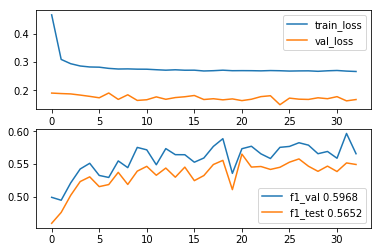

Epoch 34/100
30080/30160 [============================>.] - ETA: 0s - loss: 0.2689 - acc: 0.8887

KeyboardInterrupt: ignored

In [28]:
model.fit([train[TURNS_NAMES[i]] for i in range(3)], Y_train, epochs=100, verbose=1,
          batch_size=128,
          validation_data=([dev[TURNS_NAMES[i]] for i in range(3)], Y_dev),
          callbacks= [ Metrics([test[TURNS_NAMES[i]] for i in range(3)], Y_test, 3),
#                        ModelCheckpoint(MODEL_CHECKPOINT, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
                    ])#adam

Instructions for updating:
Use tf.cast instead.


W0426 13:02:34.487225 140707608799104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 30160 samples, validate on 2755 samples
Epoch 1/100
30160/30160 [==============================] - 218s 7ms/step - loss: 0.6464 - acc: 0.8213 - val_loss: 0.1836 - val_acc: 0.9360
— val_f1: 0.863507 — val_precision: 0.907926 — val_recall 0.823230
F1 all
0.8304900181488202
***
F1 angry: 
0.37565217391304334
****
F1 happy: 
0.5291479820627802
****
F1 others: 
0.9171441163508152
****
F1 sad: 
0.4597701149425287
****
F1 happy angry sad
0.4259259259259259
#############
F1 test:
#############
F1 all
0.8290070793247413
***
F1 angry: 
0.38546069315300074
****
F1 happy: 
0.4615384615384614
****
F1 others: 
0.9177794945370268
****
F1 sad: 
0.47486033519553067
****
F1 happy angry sad
0.41798671435871226


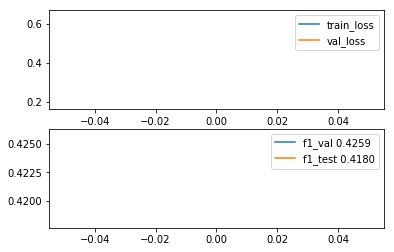

Epoch 2/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.3004 - acc: 0.8747 - val_loss: 0.2099 - val_acc: 0.9242
— val_f1: 0.834728 — val_precision: 0.900084 — val_recall 0.778221
F1 all
0.7872958257713247
***
F1 angry: 
0.3596491228070174
****
F1 happy: 
0.5960784313725489
****
F1 others: 
0.8771028037383177
****
F1 sad: 
0.6391752577319586
****
F1 happy angry sad
0.47479674796747956
#############
F1 test:
#############
F1 all
0.7956071882374295
***
F1 angry: 
0.36746987951807225
****
F1 happy: 
0.5877551020408163
****
F1 others: 
0.8856148491879349
****
F1 sad: 
0.6137931034482759
****
F1 happy angry sad
0.47206005004170126


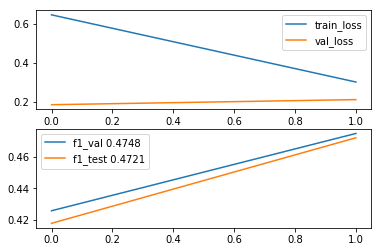

Epoch 3/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2855 - acc: 0.8804 - val_loss: 0.1940 - val_acc: 0.9304
— val_f1: 0.852001 — val_precision: 0.901540 — val_recall 0.807623
F1 all
0.8174228675136115
***
F1 angry: 
0.39999999999999997
****
F1 happy: 
0.6109090909090908
****
F1 others: 
0.8956043956043955
****
F1 sad: 
0.6787003610108302
****
F1 happy angry sad
0.5183887915936952
#############
F1 test:
#############
F1 all
0.8208386277001269
***
F1 angry: 
0.4059233449477351
****
F1 happy: 
0.5873605947955389
****
F1 others: 
0.9019697142206533
****
F1 sad: 
0.6193078324225864
****
F1 happy angry sad
0.5020134228187918


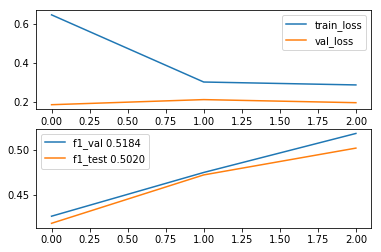

Epoch 4/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2830 - acc: 0.8830 - val_loss: 0.1988 - val_acc: 0.9328
— val_f1: 0.855429 — val_precision: 0.916252 — val_recall 0.802178
F1 all
0.812704174228675
***
F1 angry: 
0.3831775700934579
****
F1 happy: 
0.6171003717472118
****
F1 others: 
0.8945070098827854
****
F1 sad: 
0.7016129032258063
****
F1 happy angry sad
0.5056082830025883
#############
F1 test:
#############
F1 all
0.8182973316391358
***
F1 angry: 
0.39024390243902424
****
F1 happy: 
0.5957446808510638
****
F1 others: 
0.9010386942129892
****
F1 sad: 
0.6549019607843136
****
F1 happy angry sad
0.4971200708905626


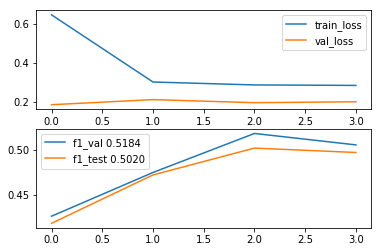

Epoch 5/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2777 - acc: 0.8835 - val_loss: 0.1683 - val_acc: 0.9407
— val_f1: 0.876388 — val_precision: 0.909766 — val_recall 0.845372
F1 all
0.8551724137931034
***
F1 angry: 
0.4725738396624471
****
F1 happy: 
0.6305084745762711
****
F1 others: 
0.919099621127702
****
F1 sad: 
0.7007874015748029
****
F1 happy angry sad
0.5747800586510262
#############
F1 test:
#############
F1 all
0.8500635324015247
***
F1 angry: 
0.471578947368421
****
F1 happy: 
0.5953654188948304
****
F1 others: 
0.9193817413543866
****
F1 sad: 
0.6147859922178988
****
F1 happy angry sad
0.5422222222222222


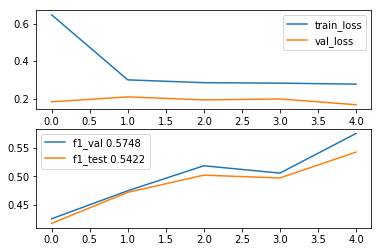

Epoch 6/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2767 - acc: 0.8855 - val_loss: 0.2041 - val_acc: 0.9275
— val_f1: 0.847135 — val_precision: 0.890713 — val_recall 0.807623
F1 all
0.8137931034482756
***
F1 angry: 
0.4044233807266982
****
F1 happy: 
0.6131386861313867
****
F1 others: 
0.8933916647478699
****
F1 sad: 
0.6923076923076922
****
F1 happy angry sad
0.5175664095972579
#############
F1 test:
#############
F1 all
0.8095843165728807
***
F1 angry: 
0.39028213166144193
****
F1 happy: 
0.6041275797373358
****
F1 others: 
0.8937492805341314
****
F1 sad: 
0.6436781609195401
****
F1 happy angry sad
0.4959244959244959


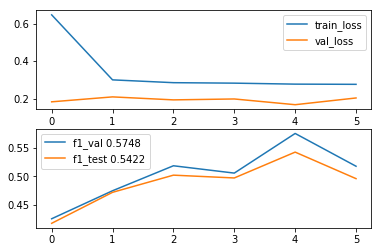

Epoch 7/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2740 - acc: 0.8869 - val_loss: 0.1788 - val_acc: 0.9371
— val_f1: 0.868759 — val_precision: 0.906830 — val_recall 0.833757
F1 all
0.8431941923774954
***
F1 angry: 
0.4589552238805969
****
F1 happy: 
0.6408450704225351
****
F1 others: 
0.911512415349887
****
F1 sad: 
0.6923076923076922
****
F1 happy angry sad
0.5629629629629629
#############
F1 test:
#############
F1 all
0.8435287711018332
***
F1 angry: 
0.45192307692307687
****
F1 happy: 
0.6165137614678897
****
F1 others: 
0.9143497757847533
****
F1 sad: 
0.6471734892787524
****
F1 happy angry sad
0.542421353670162


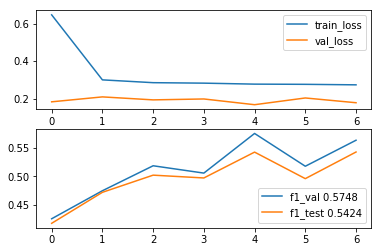

Epoch 8/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2734 - acc: 0.8857 - val_loss: 0.1834 - val_acc: 0.9333
— val_f1: 0.861295 — val_precision: 0.897013 — val_recall 0.828312
F1 all
0.8344827586206897
***
F1 angry: 
0.44484629294755873
****
F1 happy: 
0.6382978723404256
****
F1 others: 
0.9059518400726941
****
F1 sad: 
0.6739926739926738
****
F1 happy angry sad
0.5505415162454872
#############
F1 test:
#############
F1 all
0.8355418406244326
***
F1 angry: 
0.4454713493530498
****
F1 happy: 
0.6145251396648044
****
F1 others: 
0.9104056038865663
****
F1 sad: 
0.6131386861313868
****
F1 happy angry sad
0.5297646515920627


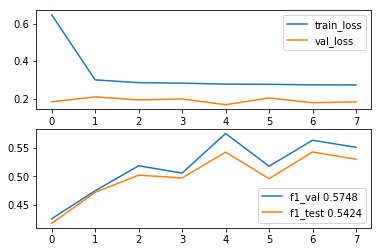

Epoch 9/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2734 - acc: 0.8870 - val_loss: 0.1970 - val_acc: 0.9280
— val_f1: 0.848762 — val_precision: 0.892986 — val_recall 0.808711
F1 all
0.8174228675136115
***
F1 angry: 
0.4261744966442952
****
F1 happy: 
0.6237942122186495
****
F1 others: 
0.8942639944713198
****
F1 sad: 
0.66412213740458
****
F1 happy angry sad
0.5320786997433702
#############
F1 test:
#############
F1 all
0.8133962606643673
***
F1 angry: 
0.4037162162162161
****
F1 happy: 
0.6003372681281618
****
F1 others: 
0.8951899896682355
****
F1 sad: 
0.6226415094339621
****
F1 happy angry sad
0.5045513654096228


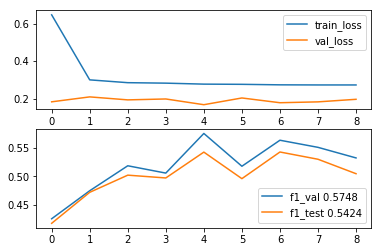

Epoch 10/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2736 - acc: 0.8872 - val_loss: 0.1677 - val_acc: 0.9447
— val_f1: 0.885203 — val_precision: 0.920784 — val_recall 0.852269
F1 all
0.8613430127041741
***
F1 angry: 
0.474012474012474
****
F1 happy: 
0.5769230769230768
****
F1 others: 
0.9277214631996472
****
F1 sad: 
0.6839826839826839
****
F1 happy angry sad
0.5514403292181069
#############
F1 test:
#############
F1 all
0.860228716645489
***
F1 angry: 
0.46121593291404606
****
F1 happy: 
0.5877712031558184
****
F1 others: 
0.9292618629173988
****
F1 sad: 
0.6181015452538631
****
F1 happy angry sad
0.5318704284221525


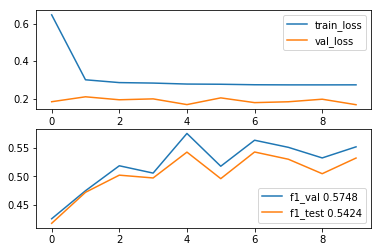

Epoch 11/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2721 - acc: 0.8872 - val_loss: 0.1681 - val_acc: 0.9396
— val_f1: 0.874506 — val_precision: 0.907813 — val_recall 0.843557
F1 all
0.8515426497277676
***
F1 angry: 
0.4822134387351778
****
F1 happy: 
0.6102941176470588
****
F1 others: 
0.9182305630026809
****
F1 sad: 
0.6718749999999999
****
F1 happy angry sad
0.562862669245648
#############
F1 test:
#############
F1 all
0.8504265746959521
***
F1 angry: 
0.46812749003984055
****
F1 happy: 
0.6057142857142856
****
F1 others: 
0.9207126948775054
****
F1 sad: 
0.6168958742632612
****
F1 happy angry sad
0.5407262021589793


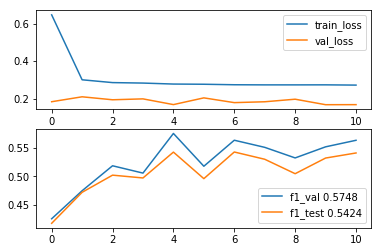

Epoch 12/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2731 - acc: 0.8871 - val_loss: 0.1779 - val_acc: 0.9364
— val_f1: 0.867761 — val_precision: 0.903378 — val_recall 0.834846
F1 all
0.8402903811252268
***
F1 angry: 
0.4506517690875232
****
F1 happy: 
0.624561403508772
****
F1 others: 
0.911060948081264
****
F1 sad: 
0.6744186046511628
****
F1 happy angry sad
0.5499999999999999
#############
F1 test:
#############
F1 all
0.840987475040842
***
F1 angry: 
0.4434050514499532
****
F1 happy: 
0.6106032906764167
****
F1 others: 
0.9148768694478802
****
F1 sad: 
0.6326129666011786
****
F1 happy angry sad
0.5317647058823527


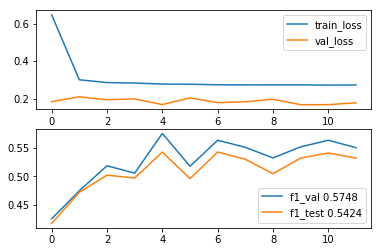

Epoch 13/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2715 - acc: 0.8871 - val_loss: 0.1670 - val_acc: 0.9416
— val_f1: 0.878480 — val_precision: 0.911753 — val_recall 0.847550
F1 all
0.8573502722323048
***
F1 angry: 
0.46929824561403494
****
F1 happy: 
0.6
****
F1 others: 
0.9218887908208296
****
F1 sad: 
0.6746031746031745
****
F1 happy angry sad
0.5582822085889569
#############
F1 test:
#############
F1 all
0.8540569976402249
***
F1 angry: 
0.4479830148619956
****
F1 happy: 
0.5873015873015873
****
F1 others: 
0.9241440052845975
****
F1 sad: 
0.609406952965235
****
F1 happy angry sad
0.525064599483204


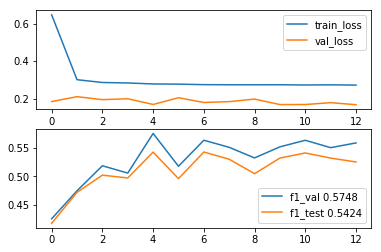

Epoch 14/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2693 - acc: 0.8891 - val_loss: 0.1679 - val_acc: 0.9418
— val_f1: 0.879262 — val_precision: 0.913861 — val_recall 0.847187
F1 all
0.8555353901996369
***
F1 angry: 
0.48192771084337344
****
F1 happy: 
0.6323529411764705
****
F1 others: 
0.9204722655379816
****
F1 sad: 
0.6772908366533865
****
F1 happy angry sad
0.5700293829578843
#############
F1 test:
#############
F1 all
0.8495189689598837
***
F1 angry: 
0.4538152610441767
****
F1 happy: 
0.5988483685220728
****
F1 others: 
0.9204797867614393
****
F1 sad: 
0.6197183098591548
****
F1 happy angry sad
0.5322740814299899


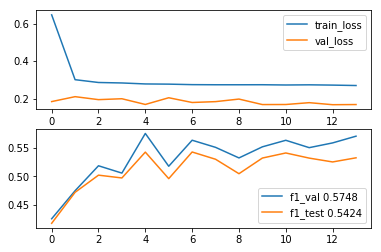

Epoch 15/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2685 - acc: 0.8895 - val_loss: 0.2073 - val_acc: 0.9229
— val_f1: 0.838722 — val_precision: 0.880943 — val_recall 0.800363
F1 all
0.8058076225045371
***
F1 angry: 
0.4075829383886255
****
F1 happy: 
0.6349206349206349
****
F1 others: 
0.8842840512223514
****
F1 sad: 
0.6891385767790261
****
F1 happy angry sad
0.528395061728395
#############
F1 test:
#############
F1 all
0.8039571610092576
***
F1 angry: 
0.3987240829346091
****
F1 happy: 
0.5990016638935107
****
F1 others: 
0.8878580540415167
****
F1 sad: 
0.6333333333333332
****
F1 happy angry sad
0.5018789144050103


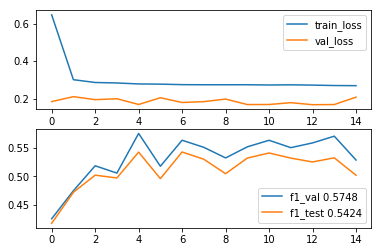

Epoch 16/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2701 - acc: 0.8870 - val_loss: 0.1615 - val_acc: 0.9434
— val_f1: 0.883268 — val_precision: 0.912858 — val_recall 0.855535
F1 all
0.8646098003629763
***
F1 angry: 
0.5054466230936818
****
F1 happy: 
0.6289752650176677
****
F1 others: 
0.9256637168141592
****
F1 sad: 
0.6854838709677419
****
F1 happy angry sad
0.5858585858585857
#############
F1 test:
#############
F1 all
0.8622254492648392
***
F1 angry: 
0.48728813559322026
****
F1 happy: 
0.6062846580406653
****
F1 others: 
0.9274594236502152
****
F1 sad: 
0.6554621848739495
****
F1 happy angry sad
0.5609382967873533


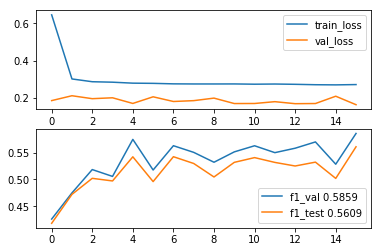

Epoch 17/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2703 - acc: 0.8885 - val_loss: 0.1794 - val_acc: 0.9340
— val_f1: 0.862804 — val_precision: 0.898585 — val_recall 0.829764
F1 all
0.8352087114337567
***
F1 angry: 
0.4388489208633093
****
F1 happy: 
0.6267605633802816
****
F1 others: 
0.9076086956521738
****
F1 sad: 
0.6771653543307085
****
F1 happy angry sad
0.542961608775137
#############
F1 test:
#############
F1 all
0.8368124886549281
***
F1 angry: 
0.448148148148148
****
F1 happy: 
0.5897435897435895
****
F1 others: 
0.9112412705564316
****
F1 sad: 
0.6303501945525292
****
F1 happy angry sad
0.52803738317757


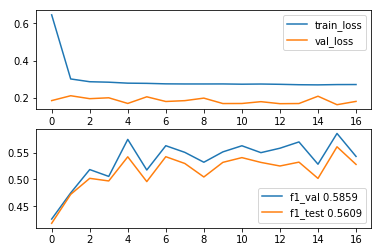

Epoch 18/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2715 - acc: 0.8870 - val_loss: 0.1705 - val_acc: 0.9417
— val_f1: 0.879729 — val_precision: 0.913604 — val_recall 0.848276
F1 all
0.8584392014519056
***
F1 angry: 
0.49583333333333324
****
F1 happy: 
0.6416382252559726
****
F1 others: 
0.9202234636871508
****
F1 sad: 
0.7099236641221373
****
F1 happy angry sad
0.5913043478260869
#############
F1 test:
#############
F1 all
0.8546015610818659
***
F1 angry: 
0.47368421052631565
****
F1 happy: 
0.6088495575221238
****
F1 others: 
0.9220663549320862
****
F1 sad: 
0.6525911708253358
****
F1 happy angry sad
0.5569744597249509


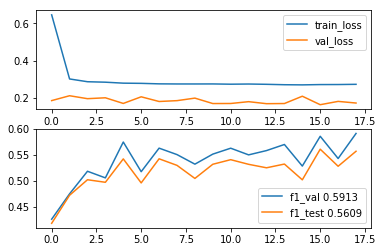

Epoch 19/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2681 - acc: 0.8897 - val_loss: 0.1713 - val_acc: 0.9436
— val_f1: 0.883073 — val_precision: 0.917449 — val_recall 0.851180
F1 all
0.858802177858439
***
F1 angry: 
0.4606060606060604
****
F1 happy: 
0.6618705035971223
****
F1 others: 
0.9223257878384374
****
F1 sad: 
0.7099567099567098
****
F1 happy angry sad
0.5737051792828683
#############
F1 test:
#############
F1 all
0.8587765474677799
***
F1 angry: 
0.4707070707070707
****
F1 happy: 
0.6194029850746268
****
F1 others: 
0.9256143458047376
****
F1 sad: 
0.6593886462882095
****
F1 happy angry sad
0.5544354838709676


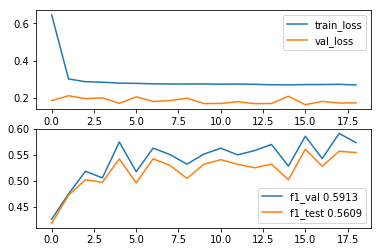

Epoch 20/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2704 - acc: 0.8878 - val_loss: 0.1649 - val_acc: 0.9416
— val_f1: 0.878993 — val_precision: 0.911180 — val_recall 0.849002
F1 all
0.8584392014519056
***
F1 angry: 
0.4774193548387095
****
F1 happy: 
0.6153846153846152
****
F1 others: 
0.9227021040974528
****
F1 sad: 
0.674074074074074
****
F1 happy angry sad
0.5668341708542712
#############
F1 test:
#############
F1 all
0.857142857142857
***
F1 angry: 
0.4755838641188959
****
F1 happy: 
0.59009900990099
****
F1 others: 
0.9254954057345288
****
F1 sad: 
0.6282527881040891
****
F1 happy angry sad
0.5460957178841309


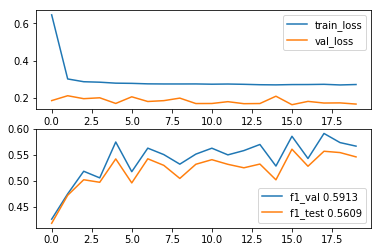

Epoch 21/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2690 - acc: 0.8891 - val_loss: 0.1723 - val_acc: 0.9368
— val_f1: 0.869760 — val_precision: 0.897644 — val_recall 0.843557
F1 all
0.8515426497277676
***
F1 angry: 
0.4891774891774891
****
F1 happy: 
0.5957446808510638
****
F1 others: 
0.9179521573887769
****
F1 sad: 
0.6666666666666665
****
F1 happy angry sad
0.5650916104146576
#############
F1 test:
#############
F1 all
0.8497004901070974
***
F1 angry: 
0.4783068783068781
****
F1 happy: 
0.5907590759075907
****
F1 others: 
0.9182263814616756
****
F1 sad: 
0.6313645621181262
****
F1 happy angry sad
0.5484818805093046


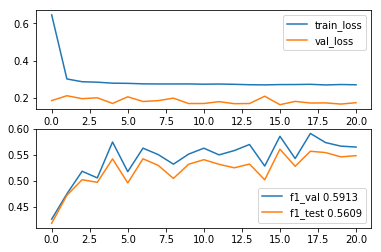

Epoch 22/100
30160/30160 [==============================] - 187s 6ms/step - loss: 0.2655 - acc: 0.8904 - val_loss: 0.1763 - val_acc: 0.9366
— val_f1: 0.869175 — val_precision: 0.897218 — val_recall 0.842831
F1 all
0.8482758620689654
***
F1 angry: 
0.4912280701754385
****
F1 happy: 
0.636986301369863
****
F1 others: 
0.9132296596799638
****
F1 sad: 
0.6865671641791044
****
F1 happy angry sad
0.5796831314072692
#############
F1 test:
#############
F1 all
0.8458885460156107
***
F1 angry: 
0.46317829457364323
****
F1 happy: 
0.6115107913669063
****
F1 others: 
0.9161522056347512
****
F1 sad: 
0.6525911708253358
****
F1 happy angry sad
0.5490753911806542


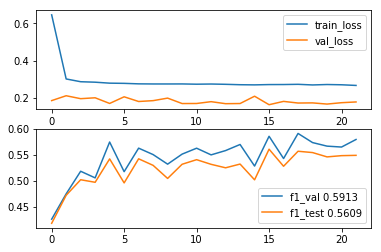

Epoch 23/100
30160/30160 [==============================] - 191s 6ms/step - loss: 0.2663 - acc: 0.8902 - val_loss: 0.1665 - val_acc: 0.9459
— val_f1: 0.887674 — val_precision: 0.923167 — val_recall 0.854809
F1 all
0.8638838475499092
***
F1 angry: 
0.4624999999999999
****
F1 happy: 
0.6159999999999999
****
F1 others: 
0.9285243017374092
****
F1 sad: 
0.6952789699570814
****
F1 happy angry sad
0.5586708203530633
#############
F1 test:
#############
F1 all
0.8660373933563259
***
F1 angry: 
0.4780793319415448
****
F1 happy: 
0.5927419354838709
****
F1 others: 
0.9313413160496539
****
F1 sad: 
0.6767895878524945
****
F1 happy angry sad
0.5556135770234986


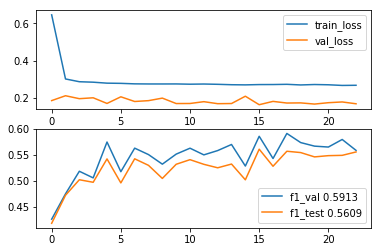

Epoch 24/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2710 - acc: 0.8878 - val_loss: 0.1721 - val_acc: 0.9393
— val_f1: 0.874460 — val_precision: 0.905206 — val_recall 0.845735
F1 all
0.8519056261343012
***
F1 angry: 
0.47398843930635826
****
F1 happy: 
0.643598615916955
****
F1 others: 
0.9175627240143367
****
F1 sad: 
0.6974789915966385
****
F1 happy angry sad
0.5717017208413001
#############
F1 test:
#############
F1 all
0.852967870756943
***
F1 angry: 
0.4696517412935322
****
F1 happy: 
0.6093189964157706
****
F1 others: 
0.9208152355496156
****
F1 sad: 
0.6680672268907561
****
F1 happy angry sad
0.5541932319764589


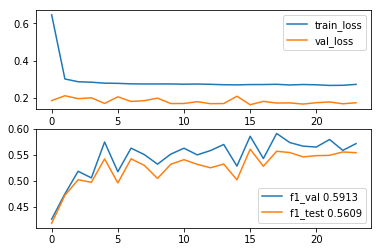

Epoch 25/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2695 - acc: 0.8885 - val_loss: 0.1671 - val_acc: 0.9407
— val_f1: 0.877711 — val_precision: 0.905129 — val_recall 0.851906
F1 all
0.8609800362976405
***
F1 angry: 
0.5130434782608695
****
F1 happy: 
0.6249999999999999
****
F1 others: 
0.9219098616688977
****
F1 sad: 
0.7096774193548385
****
F1 happy angry sad
0.5953307392996108
#############
F1 test:
#############
F1 all
0.8593211109094209
***
F1 angry: 
0.4983606557377049
****
F1 happy: 
0.6133768352365415
****
F1 others: 
0.9224961137019764
****
F1 sad: 
0.6776859504132231
****
F1 happy angry sad
0.5765407554671966


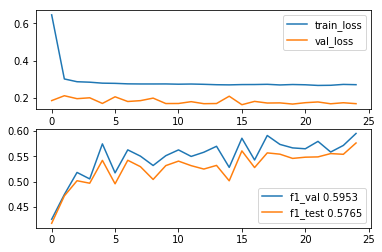

Epoch 26/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2679 - acc: 0.8888 - val_loss: 0.1756 - val_acc: 0.9386
— val_f1: 0.871640 — val_precision: 0.910962 — val_recall 0.835572
F1 all
0.8464609800362976
***
F1 angry: 
0.4689922480620154
****
F1 happy: 
0.6308243727598565
****
F1 others: 
0.913258426966292
****
F1 sad: 
0.6867924528301885
****
F1 happy angry sad
0.5660377358490565
#############
F1 test:
#############
F1 all
0.8431657288074059
***
F1 angry: 
0.43972999035679833
****
F1 happy: 
0.5849056603773584
****
F1 others: 
0.9172915500839394
****
F1 sad: 
0.635658914728682
****
F1 happy angry sad
0.5252040326452231


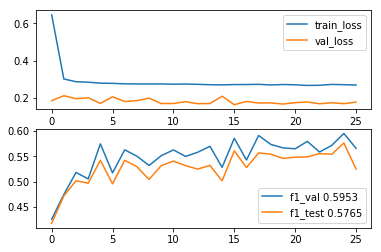

Epoch 27/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2696 - acc: 0.8887 - val_loss: 0.1884 - val_acc: 0.9294
— val_f1: 0.852986 — val_precision: 0.889633 — val_recall 0.819238
F1 all
0.8257713248638837
***
F1 angry: 
0.4391080617495711
****
F1 happy: 
0.6315789473684209
****
F1 others: 
0.8994055784179241
****
F1 sad: 
0.6746987951807228
****
F1 happy angry sad
0.5422535211267605
#############
F1 test:
#############
F1 all
0.828099473588673
***
F1 angry: 
0.430182133564614
****
F1 happy: 
0.6076388888888888
****
F1 others: 
0.9053900386627245
****
F1 sad: 
0.6383838383838383
****
F1 happy angry sad
0.5224820143884892


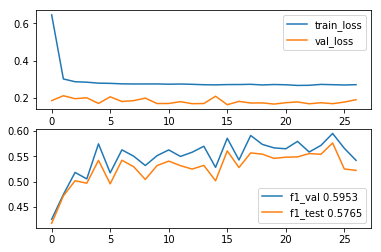

Epoch 28/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2663 - acc: 0.8900 - val_loss: 0.1666 - val_acc: 0.9421
— val_f1: 0.880658 — val_precision: 0.908530 — val_recall 0.854446
F1 all
0.8624319419237749
***
F1 angry: 
0.49032258064516115
****
F1 happy: 
0.644927536231884
****
F1 others: 
0.9235555555555555
****
F1 sad: 
0.7063197026022304
****
F1 happy angry sad
0.5900990099009898
#############
F1 test:
#############
F1 all
0.8567798148484297
***
F1 angry: 
0.47720042417815467
****
F1 happy: 
0.6194029850746268
****
F1 others: 
0.9228377928278005
****
F1 sad: 
0.6503759398496239
****
F1 happy angry sad
0.5609149676777722


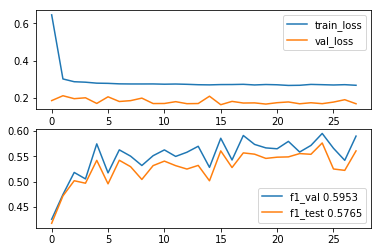

Epoch 29/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2678 - acc: 0.8899 - val_loss: 0.1685 - val_acc: 0.9402
— val_f1: 0.876615 — val_precision: 0.905259 — val_recall 0.849728
F1 all
0.8569872958257713
***
F1 angry: 
0.4908722109533469
****
F1 happy: 
0.6433566433566432
****
F1 others: 
0.9205357142857141
****
F1 sad: 
0.6852589641434261
****
F1 happy angry sad
0.5805825242718445
#############
F1 test:
#############
F1 all
0.8553276456707206
***
F1 angry: 
0.4683417085427135
****
F1 happy: 
0.6128440366972475
****
F1 others: 
0.9225978647686832
****
F1 sad: 
0.6748971193415637
****
F1 happy angry sad
0.5567620927936819


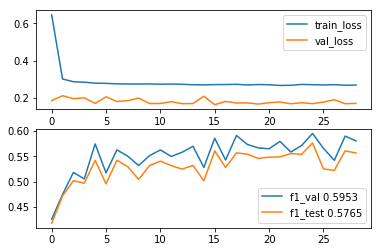

Epoch 30/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2688 - acc: 0.8885 - val_loss: 0.1669 - val_acc: 0.9387
— val_f1: 0.874417 — val_precision: 0.899770 — val_recall 0.850454
F1 all
0.8573502722323048
***
F1 angry: 
0.5094736842105263
****
F1 happy: 
0.6312292358803986
****
F1 others: 
0.9193296089385474
****
F1 sad: 
0.6872586872586871
****
F1 happy angry sad
0.5893719806763285
#############
F1 test:
#############
F1 all
0.8585950263205663
***
F1 angry: 
0.494646680942184
****
F1 happy: 
0.6206896551724137
****
F1 others: 
0.9230255839822025
****
F1 sad: 
0.6614785992217899
****
F1 happy angry sad
0.5729783037475344


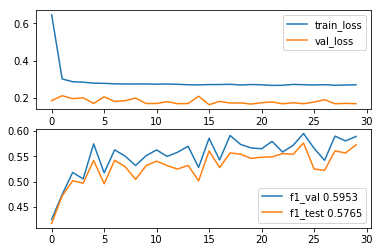

Epoch 31/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2685 - acc: 0.8891 - val_loss: 0.1713 - val_acc: 0.9430
— val_f1: 0.881241 — val_precision: 0.919858 — val_recall 0.845735
F1 all
0.8555353901996369
***
F1 angry: 
0.46183953033268094
****
F1 happy: 
0.6053639846743294
****
F1 others: 
0.9223236145114623
****
F1 sad: 
0.7183673469387755
****
F1 happy angry sad
0.5604719764011798
#############
F1 test:
#############
F1 all
0.8575058994372843
***
F1 angry: 
0.4629441624365482
****
F1 happy: 
0.5968992248062015
****
F1 others: 
0.9253268335918456
****
F1 sad: 
0.6761710794297352
****
F1 happy angry sad
0.5502008032128513


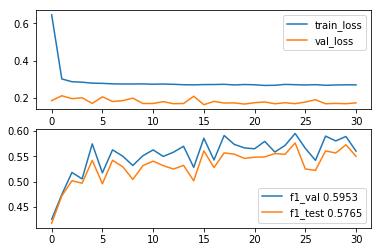

Epoch 32/100
30160/30160 [==============================] - 188s 6ms/step - loss: 0.2680 - acc: 0.8893 - val_loss: 0.1781 - val_acc: 0.9335
— val_f1: 0.862613 — val_precision: 0.893121 — val_recall 0.834120
F1 all
0.8406533575317603
***
F1 angry: 
0.4748490945674044
****
F1 happy: 
0.6026490066225165
****
F1 others: 
0.9097472924187724
****
F1 sad: 
0.6523297491039425
****
F1 happy angry sad
0.5565862708719851
#############
F1 test:
#############
F1 all
0.8382646578326374
***
F1 angry: 
0.45582329317269066
****
F1 happy: 
0.5749128919860627
****
F1 others: 
0.9113781871279344
****
F1 sad: 
0.6201834862385319
****
F1 happy angry sad
0.5304964539007091


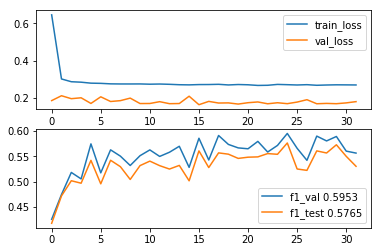

Epoch 33/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2674 - acc: 0.8894 - val_loss: 0.1753 - val_acc: 0.9392
— val_f1: 0.873394 — val_precision: 0.910918 — val_recall 0.838838
F1 all
0.8468239564428311
***
F1 angry: 
0.46037735849056594
****
F1 happy: 
0.6209386281588447
****
F1 others: 
0.9151324651998203
****
F1 sad: 
0.6987951807228914
****
F1 happy angry sad
0.5587121212121211
#############
F1 test:
#############
F1 all
0.8495189689598837
***
F1 angry: 
0.45142857142857135
****
F1 happy: 
0.6041275797373358
****
F1 others: 
0.9200178731009829
****
F1 sad: 
0.6790890269151137
****
F1 happy angry sad
0.5440464666021296


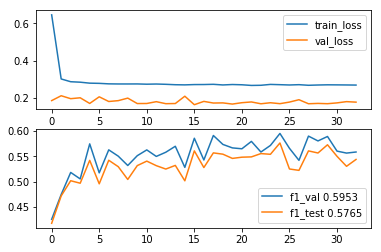

Epoch 34/100
30160/30160 [==============================] - 190s 6ms/step - loss: 0.2703 - acc: 0.8884 - val_loss: 0.1599 - val_acc: 0.9487
— val_f1: 0.893577 — val_precision: 0.928739 — val_recall 0.860980
F1 all
0.8711433756805806
***
F1 angry: 
0.45916114790286966
****
F1 happy: 
0.6122448979591835
****
F1 others: 
0.9350141273636164
****
F1 sad: 
0.6635071090047392
****
F1 happy angry sad
0.5478547854785476
#############
F1 test:
#############
F1 all
0.869123252858958
***
F1 angry: 
0.4629213483146066
****
F1 happy: 
0.5826446280991734
****
F1 others: 
0.934360420961267
****
F1 sad: 
0.6323185011709601
****
F1 happy angry sad
0.5352581898945029


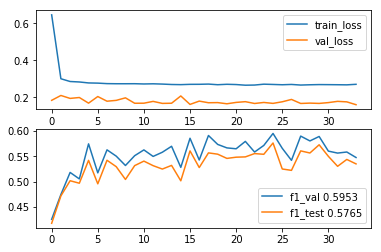

Epoch 35/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2673 - acc: 0.8901 - val_loss: 0.1745 - val_acc: 0.9367
— val_f1: 0.868550 — val_precision: 0.902544 — val_recall 0.837024
F1 all
0.843557168784029
***
F1 angry: 
0.4725897920604914
****
F1 happy: 
0.6308724832214763
****
F1 others: 
0.9125338142470694
****
F1 sad: 
0.6558704453441295
****
F1 happy angry sad
0.5586592178770948
#############
F1 test:
#############
F1 all
0.8429842076601924
***
F1 angry: 
0.45204178537511863
****
F1 happy: 
0.5946902654867255
****
F1 others: 
0.9160219755577979
****
F1 sad: 
0.6361746361746361
****
F1 happy angry sad
0.5326345878989994


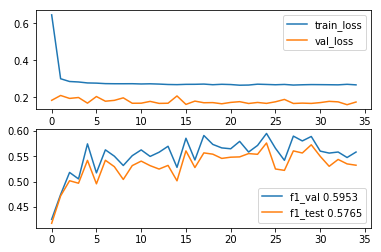

Epoch 36/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2680 - acc: 0.8883 - val_loss: 0.1660 - val_acc: 0.9437
— val_f1: 0.883668 — val_precision: 0.916212 — val_recall 0.853358
F1 all
0.8635208711433756
***
F1 angry: 
0.4812362030905077
****
F1 happy: 
0.6070038910505835
****
F1 others: 
0.9268614100593014
****
F1 sad: 
0.6639676113360322
****
F1 happy angry sad
0.5621734587251828
#############
F1 test:
#############
F1 all
0.856598293701216
***
F1 angry: 
0.4432661717921526
****
F1 happy: 
0.5828343313373252
****
F1 others: 
0.9267274524881906
****
F1 sad: 
0.6199575371549892
****
F1 happy angry sad
0.523237597911227


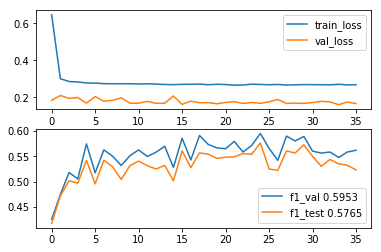

Epoch 37/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2674 - acc: 0.8896 - val_loss: 0.1767 - val_acc: 0.9384
— val_f1: 0.872488 — val_precision: 0.903891 — val_recall 0.843194
F1 all
0.849364791288566
***
F1 angry: 
0.46031746031746024
****
F1 happy: 
0.6388888888888888
****
F1 others: 
0.9153605015673979
****
F1 sad: 
0.6984126984126984
****
F1 happy angry sad
0.5670498084291187
#############
F1 test:
#############
F1 all
0.8500635324015247
***
F1 angry: 
0.46123650637880265
****
F1 happy: 
0.6223021582733811
****
F1 others: 
0.9181097084124679
****
F1 sad: 
0.6747967479674796
****
F1 happy angry sad
0.5553942912433478


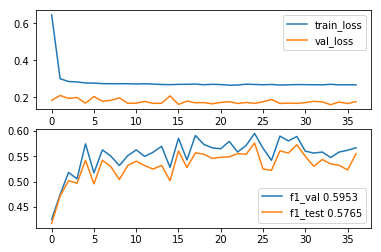

Epoch 38/100
30160/30160 [==============================] - 189s 6ms/step - loss: 0.2674 - acc: 0.8895 - val_loss: 0.1908 - val_acc: 0.9287
— val_f1: 0.852484 — val_precision: 0.881395 — val_recall 0.825408
F1 all
0.8312159709618874
***
F1 angry: 
0.47368421052631565
****
F1 happy: 
0.6242424242424243
****
F1 others: 
0.8998170173833485
****
F1 sad: 
0.681159420289855
****
F1 happy angry sad
0.5676625659050967
#############
F1 test:
#############
F1 all
0.8317298965329459
***
F1 angry: 
0.45593869731800757
****
F1 happy: 
0.6018808777429466
****
F1 others: 
0.9051194539249146
****
F1 sad: 
0.6373626373626372
****
F1 happy angry sad
0.542190305206463


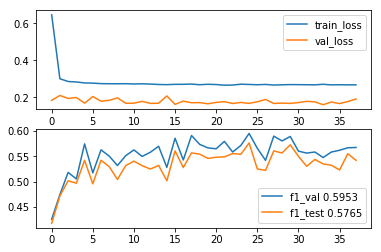

Epoch 39/100
30160/30160 [==============================] - 191s 6ms/step - loss: 0.2682 - acc: 0.8902 - val_loss: 0.1756 - val_acc: 0.9375
— val_f1: 0.869779 — val_precision: 0.907334 — val_recall 0.835209
F1 all
0.8450090744101633
***
F1 angry: 
0.47011952191235046
****
F1 happy: 
0.5993031358885016
****
F1 others: 
0.9145548329221798
****
F1 sad: 
0.6488549618320609
****
F1 happy angry sad
0.5499524262607041
#############
F1 test:
#############
F1 all
0.8408059538936284
***
F1 angry: 
0.44176706827309226
****
F1 happy: 
0.5740402193784276
****
F1 others: 
0.914910226385636
****
F1 sad: 
0.6023622047244094
****
F1 happy angry sad
0.5168210628961482


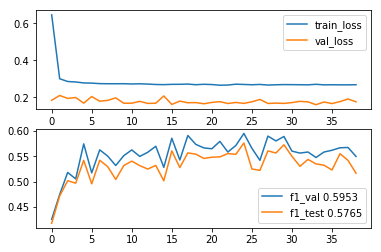

Epoch 40/100
27008/30160 [=========================>....] - ETA: 18s - loss: 0.2686 - acc: 0.8902

KeyboardInterrupt: ignored

In [26]:
model.fit([train[TURNS_NAMES[i]] for i in range(3)], Y_train, epochs=100, verbose=1,
          batch_size=128,
          validation_data=([dev[TURNS_NAMES[i]] for i in range(3)], Y_dev),
          callbacks= [ Metrics([test[TURNS_NAMES[i]] for i in range(3)], Y_test, 3),
#                        ModelCheckpoint(MODEL_CHECKPOINT, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
                    ]) # rmsprop

In [0]:
# predicts = (np.asarray(model.predict(test[TURNS_CONCAT][:3]))).round()

In [0]:
# print_metrics_predicted(predicts,test[LABEL],"elmo1.txt")

In [0]:
# with open(MODEL_CHECKPOINT + ".json", "r") as f:
#   model = model_from_json(f.read(), custom_objects={'ElmoEmbeddingLayer':ElmoEmbeddingLayer()})
  
# model.load_weights(MODEL_CHECKPOINT)

In [0]:
# loaded_model = load_model(MODEL_CHECKPOINT, custom_objects={'ElmoEmbeddingLayer':ElmoEmbeddingLayer()})

In [0]:
# predicts = (np.asarray(model.predict(test[CONCATENATED_TURNS][:3]))).round()

In [0]:
# print(predicts[:10])

In [0]:
# print_metrics_predicted(predicts, Y_test, filename=MODEL_CHECKPOINT+"-results")